In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import *
from sklearn.discriminant_analysis import *
from sklearn.naive_bayes import *
from sklearn.tree import *
import lightgbm as lgb
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
# import xgboost
from sklearn.metrics import log_loss
%matplotlib inline

/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# DATA IMPORT

In [2]:
%pwd

'/Users/doyoung/Walmart_classification'

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# DATA STRUCTURE

In [4]:
def submission_format(title_csv):
    submission_df = pd.DataFrame(predict_prob)
    submission_df.insert(0,'VisitNumber', sample_submission['VisitNumber'])
    submission_df.head()
    
    submission_df.columns = sample_submission.columns
    
    print(submission_df.shape)
    submission_df.head()
    
    submission_df.to_csv(title_csv, index = False)

In [5]:
def plot_decision_regions(X, y, model, title):
    resolution = 0.01
    markers = ('s', '^', 'o')
    colors = ('red', 'blue', 'lightgreen')
    cmap = mpl.colors.ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], s=80, label=cl)

    plt.xlabel(iris.feature_names[2])
    plt.ylabel(iris.feature_names[3])
    plt.legend(loc='upper left')
    plt.title(title)
    
    return Z

In [6]:
def find_missing_values(df):
    try:

        missing = df.isnull().sum()
        missing = missing[missing >0]

        missing.sort_values(inplace = True)
        print(missing)

        missing.plot(kind = 'bar')
        plt.show()
        
    except:
        print("No missing values")
        
def missing_values_idx(df):
    
    missing = df.isnull().sum()
    missing = missing[missing >0]

    missing_col = missing.index

    for col in missing_col:
        missing_idx = df[col].isnull()
        missing_idx = missing_idx[missing_idx].index
        print(missing_idx, col)
        print("\\")

In [7]:
# 한 사람당 몇개의 department제품을 사는지 알아보는 컬럼
def add_category_counts(data):
    alist = []
    for array in np.asarray(data.iloc[:,4:]):
        count = 0
        for item in array:
            if item > 0:
                count += 1
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"CategoryCount"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(4, 'CategoryCounts', cat_counts)
    return data

DepartmentDescription    1361
Upc                      4129
FinelineNumber           4129
dtype: int64


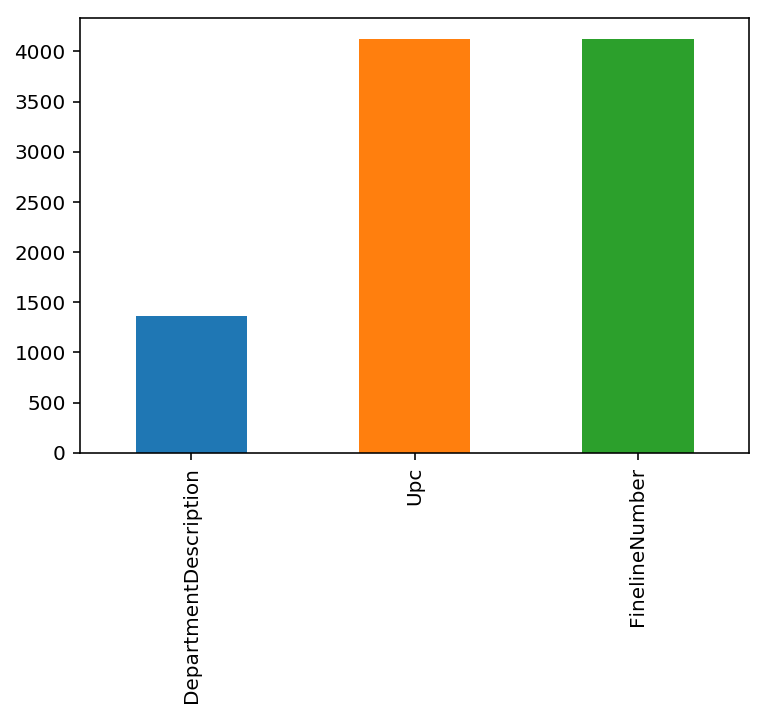

Int64Index([    25,    548,    549,    959,   1116,   1134,   1135,   1155,
              1216,   1373,
            ...
            640573, 642017, 642236, 642499, 642784, 643137, 643991, 645990,
            645991, 645992],
           dtype='int64', length=4129) Upc
\
Int64Index([    25,    548,    549,    959,   1116,   1134,   1135,   1926,
              1927,   2294,
            ...
            640573, 642017, 642236, 642499, 642784, 643137, 643991, 645990,
            645991, 645992],
           dtype='int64', length=1361) DepartmentDescription
\
Int64Index([    25,    548,    549,    959,   1116,   1134,   1135,   1155,
              1216,   1373,
            ...
            640573, 642017, 642236, 642499, 642784, 643137, 643991, 645990,
            645991, 645992],
           dtype='int64', length=4129) FinelineNumber
\


(None, None)

In [8]:
find_missing_values(train), missing_values_idx(train)

# DATA VISUALIZATION

# PREPROCESSING

In [9]:
weekday=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train['weeknum'] = np.nan
test['weeknum'] = np.nan
for idx, day in enumerate(weekday):
    train['weeknum'] = np.where(train['Weekday'] == day, idx, train['weeknum'])
    test['weeknum'] = np.where(test['Weekday'] == day, idx, test['weeknum'])

- Total number of items per visit
- Percentage of items purchased based on Department
- Percentage of items purchased based on Fineline Number
- Percentage of items purchased by UPC
- Count of different items purchased (based on UPC)
- Count of returned items
- Boolean for presence of returned item

In [10]:
train['test'] = False
test['test'] = True
train_test = pd.concat([train,test], axis=0)

In [11]:
train_test['Upc'] = train_test['Upc'].fillna(value = 9999)
train_test['FinelineNumber'] = train_test['FinelineNumber'].fillna(value = 9999)
train_test['DepartmentDescription'] = train_test['DepartmentDescription'].fillna(value = 'Nodata')

In [12]:
train_test['Return'] = np.where(train_test['ScanCount'] < 0, -train_test['ScanCount'], 0)

## BY DEPARTMENT DESCRIPTION

In [13]:
dum = pd.get_dummies(train_test['DepartmentDescription'])
dum_wk = pd.get_dummies(train_test['weeknum'])
train_test[dum.columns] = dum
train_test[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']] = dum_wk
train_test.drop(['DepartmentDescription', 'FinelineNumber', 'Upc', 'Weekday'], axis =1, inplace=True)

In [14]:
train_test.shape

(1300700, 82)

In [14]:
df_preprocessed = pd.read_csv('df_to_be_added.csv')

In [15]:
train_df = train_test[train_test['test'] == False]
test_df = train_test[train_test['test'] == True]

In [16]:
train_df.drop('test', axis=1, inplace=True)
test_df.drop('test', axis=1, inplace=True)

/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
train_df = train_df.groupby(['VisitNumber', 'TripType', 'weeknum']).agg('sum').reset_index(drop=False)
test_df = test_df.groupby(['VisitNumber', 'weeknum']).agg('sum').reset_index(drop=False)

In [18]:
train_df.head()

,VisitNumber,TripType,weeknum,ScanCount,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,...,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,5,999.0,4.0,-1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,7,30.0,4.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
2,8,26.0,4.0,28,2,0,0,0,0,0,...,0,0,0,0,0,0,0,23,0,0
3,9,8.0,4.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
4,10,8.0,4.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0


In [19]:
train_df.shape

(95674, 81)

In [20]:
train_df['TripType'] = train_df['TripType'].astype('category')
train_df['ScanCount'] = train_df['ScanCount'].astype(float)                         
train_df['VisitNumber'] = train_df['VisitNumber'].astype('category')
train_df['Return'] = train_df['Return'].astype(float)

In [21]:
test_df['TripType'] = test_df['TripType'].astype('category') 
test_df['ScanCount'] = test_df['ScanCount'].astype(float)                         
test_df['VisitNumber'] = test_df['VisitNumber'].astype('category')
test_df['Return'] = test_df['Return'].astype(float)

In [22]:
'''
모델 성능 평가를 위하여 train set을 7:3 로 나눠서 크로스 밸리데이션
'''
model_train_df, model_test_df = train_test_split(train_df, test_size = .3) 

In [23]:
model_train_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']] = np.where(model_train_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']] >= 1, 1, 0)
model_test_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']] = np.where(model_test_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']] >= 1, 1, 0)

/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set 

In [24]:
y = model_train_df['TripType']
X = model_train_df.drop(['TripType', 'VisitNumber', 'weeknum'], axis=1)

In [25]:
test_X = model_test_df.drop(['TripType', 'VisitNumber', 'weeknum'], axis=1)


In [26]:
y_actual = model_test_df['TripType']

In [27]:
train_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']] = np.where(train_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']] >= 1, 1, 0)
test_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']] = np.where(test_df[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']] >= 1, 1, 0)
y0 = train_df['TripType']
X0 = train_df.drop(['TripType', 'VisitNumber', 'weeknum'], axis=1)

In [28]:
set(test_df.columns) - set(X0.columns)

{'TripType', 'VisitNumber', 'weeknum'}

In [29]:
X0.head()

,ScanCount,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,...,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,-1.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28.0,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,3.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [30]:
X0.shape

(95674, 78)

### BY DEPARTMENT DESCRIPTION DECISION TREE

In [38]:
X0.shape, y0.shape

((95674, 78), (95674,))

In [39]:
forest_model_origin = ExtraTreesClassifier(n_estimators=100, random_state=0).fit(X,y)
y_hat = pd.Series(forest_model_origin.predict(test_X)).astype('float64')

In [40]:
confusion_matrix(y_actual, y_hat)

array([[1040,    0,    0, ...,    0,    0,    1],
       [   0,    3,   81, ...,    0,    0,    0],
       [   0,   13, 1050, ...,    1,    0,   10],
       ...,
       [   0,    0,   17, ...,    3,    0,    3],
       [   0,    0,    2, ...,    4,    8,    0],
       [ 207,    0,   21, ...,    0,    0, 1903]])

In [41]:
target_names = list(train_df['TripType'].unique())

In [42]:
print(classification_report(y_actual, y_hat, ))

             precision    recall  f1-score   support

        3.0       0.77      0.96      0.86      1082
        4.0       0.12      0.03      0.05        93
        5.0       0.71      0.80      0.75      1311
        6.0       0.65      0.72      0.69       361
        7.0       0.63      0.67      0.65      1684
        8.0       0.77      0.82      0.79      3659
        9.0       0.68      0.77      0.72      2845
       12.0       0.00      0.00      0.00        76
       14.0       0.00      0.00      0.00         2
       15.0       0.49      0.38      0.43       286
       18.0       0.45      0.34      0.39       177
       19.0       0.33      0.22      0.26       125
       20.0       0.64      0.58      0.61       192
       21.0       0.59      0.48      0.53       208
       22.0       0.45      0.27      0.34       281
       23.0       0.44      0.25      0.32        55
       24.0       0.59      0.55      0.57       773
       25.0       0.65      0.71      0.68   

Feature ranking:
1. feature ScanCount (0.146699)
2. feature Return (0.048048)
3. feature DSD GROCERY (0.042822)
4. feature GROCERY DRY GOODS (0.033832)
5. feature FINANCIAL SERVICES (0.033494)
6. feature PERSONAL CARE (0.032903)
7. feature PRODUCE (0.031117)
8. feature PHARMACY OTC (0.030726)
9. feature DAIRY (0.027738)
10. feature IMPULSE MERCHANDISE (0.024416)
11. feature SERVICE DELI (0.023481)
12. feature HOUSEHOLD CHEMICALS/SUPP (0.021298)
13. feature MENS WEAR (0.020897)
14. feature PHARMACY RX (0.018491)
15. feature INFANT CONSUMABLE HARDLINES (0.017624)
16. feature BEAUTY (0.017580)
17. feature FROZEN FOODS (0.017222)
18. feature HOUSEHOLD PAPER GOODS (0.016187)
19. feature COMM BREAD (0.014125)
20. feature CANDY, TOBACCO, COOKIES (0.013826)
21. feature MEAT - FRESH & FROZEN (0.012704)
22. feature Sat (0.012532)
23. feature PETS AND SUPPLIES (0.012459)
24. feature LADIESWEAR (0.012442)
25. feature Sun (0.012283)
26. feature Fri (0.011939)
27. feature SHOES (0.011440)
28. featur

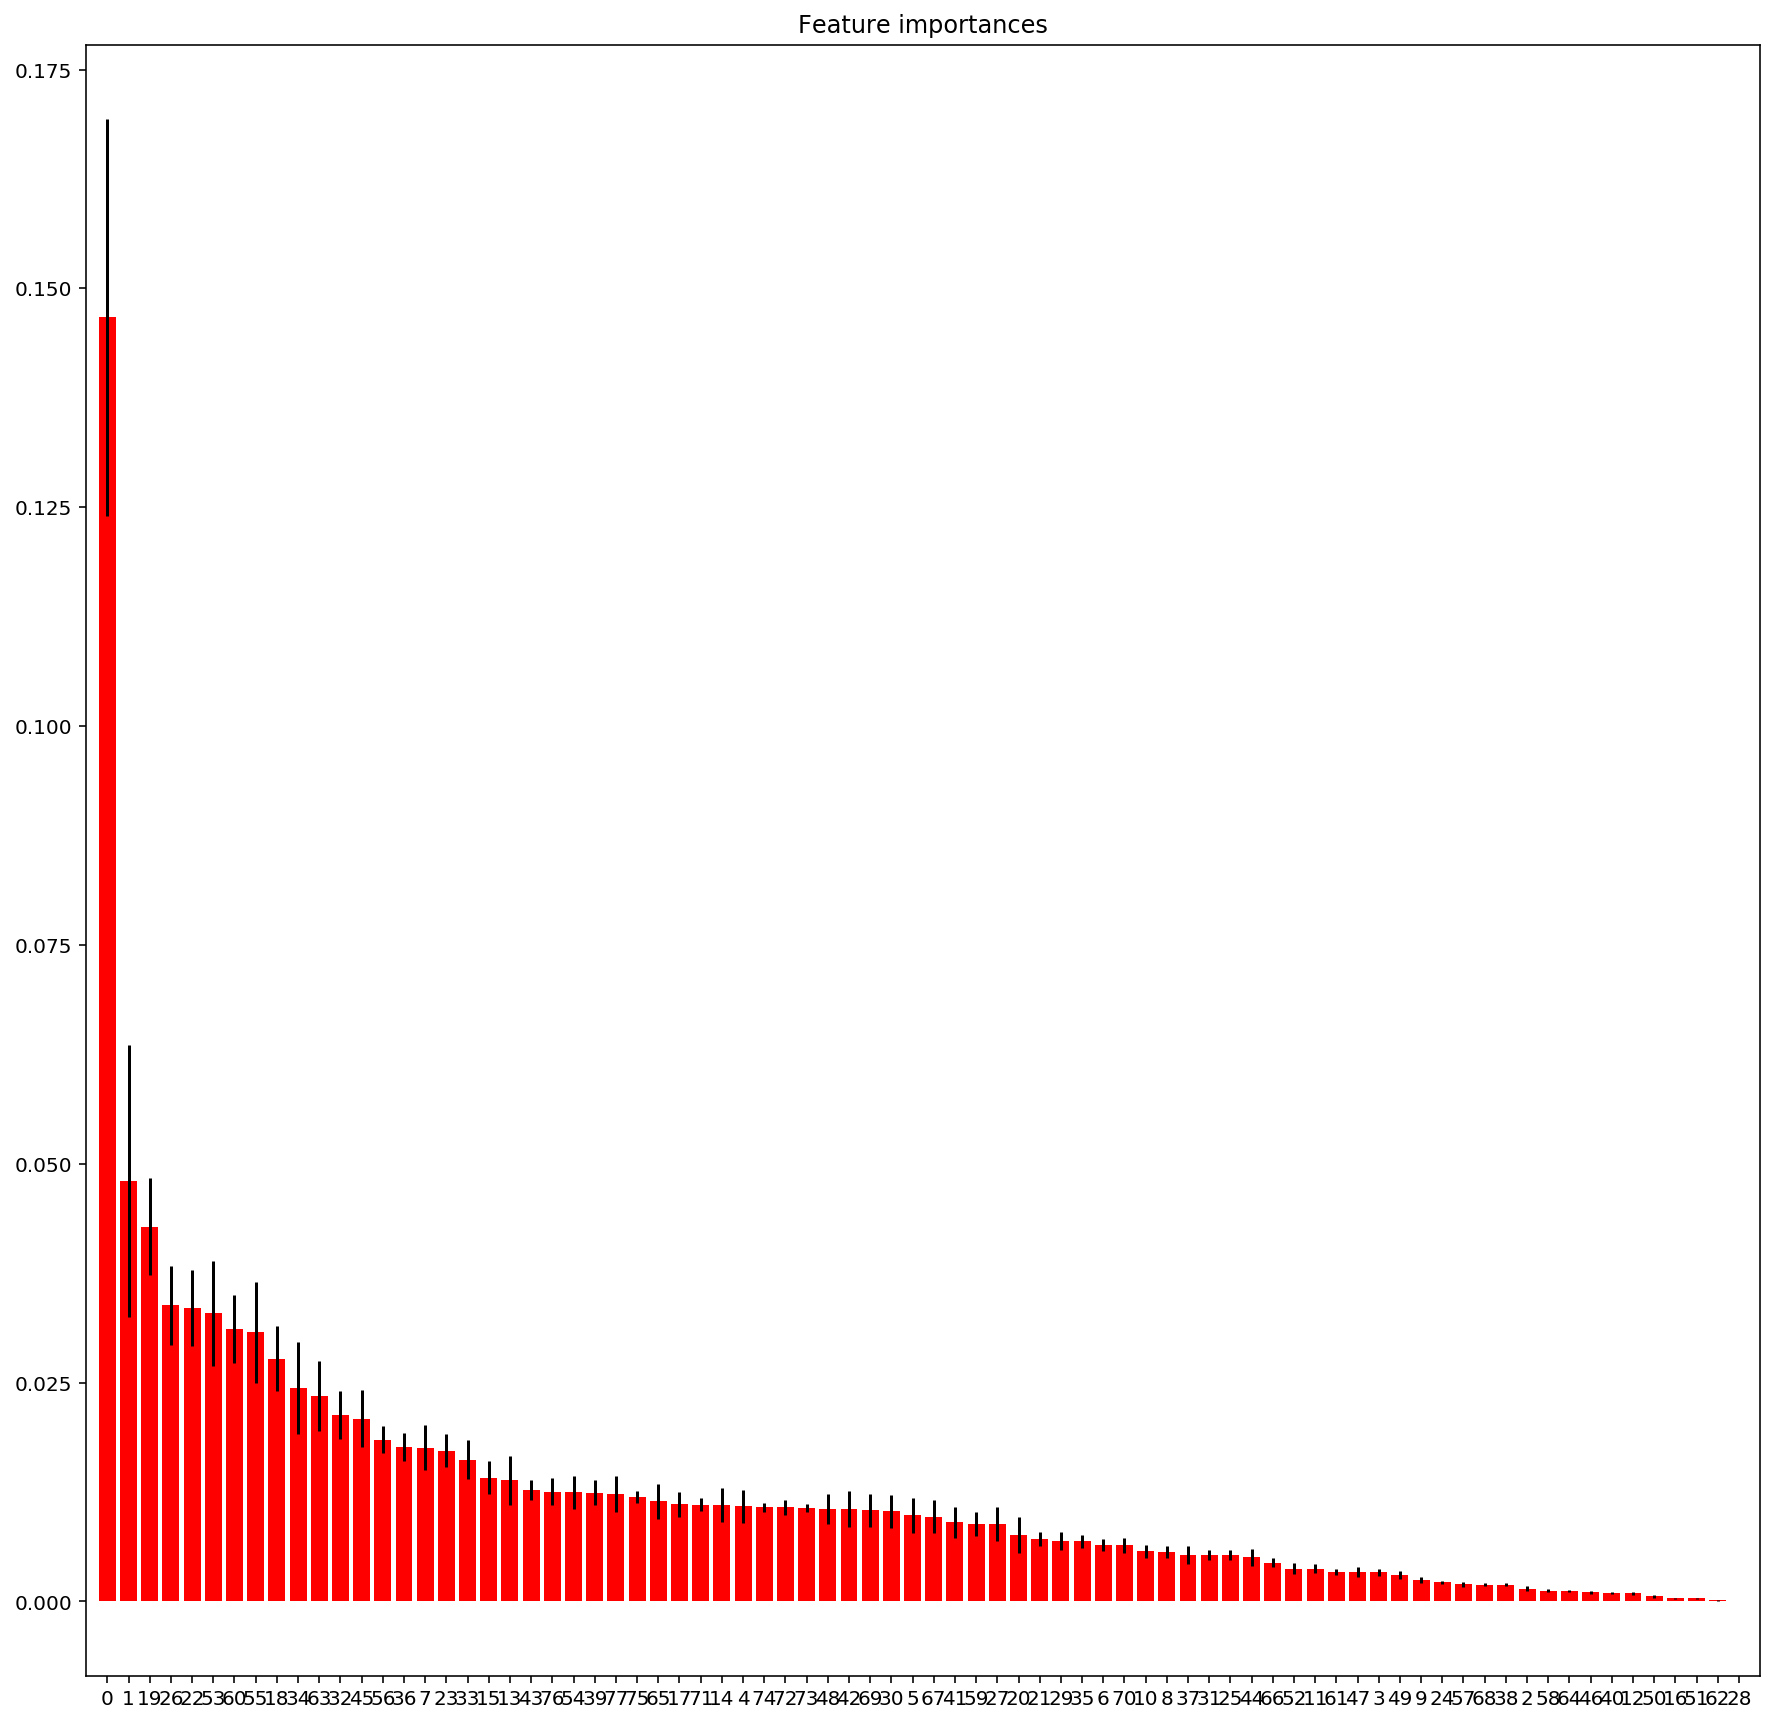

In [43]:
importances_origin = forest_model_origin.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest_model_origin.estimators_], axis=0)
indices = np.argsort(importances_origin)[::-1]
X_features = X.columns

print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_features[indices[f]], importances_origin[indices[f]]))

plt.figure(figsize=(15,15))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances_origin[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


In [44]:
X0_test = test_df.drop(['TripType', 'VisitNumber', 'weeknum'], axis=1)
X0_test.shape

(95674, 78)

In [45]:
X0.shape

(95674, 78)

# finelineNumber 더한 train set

### X1는 fineline더해진 train set
### X1_test는 fineline더해진 test set

In [46]:
grouped_fineline = pd.read_csv('grouped_fineline.csv')

In [47]:
X1 = pd.concat([X0,grouped_fineline[:95674]], axis=1)
X1.shape

(95674, 5431)

In [48]:
X1_test = test_df.drop(['TripType', 'VisitNumber', 'weeknum'], axis=1)
X1_test.shape

(95674, 78)

In [49]:
X1_test = pd.concat([X1_test,grouped_fineline[:95674]], axis=1)
X1_test.shape

(95674, 5431)

In [50]:
y0.shape

(95674,)

In [51]:
X1_y0 = pd.concat([X1, y0], axis=1)
X1_y0.shape

(95674, 5432)

In [52]:
X1_y0.head()

,ScanCount,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,...,9969.0,9970.0,9971.0,9974.0,9975.0,9991.0,9997.0,9998.0,9999.0,TripType
0,-1.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,999.0
1,2.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30.0
2,28.0,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,26.0
3,3.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
4,3.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0


In [53]:
model_train_df, model_test_df = train_test_split(X1_y0, test_size = .3) 

In [54]:
y = model_train_df['TripType']
X = model_train_df.drop(['TripType'], axis=1)

test_X = model_test_df.drop(['TripType'], axis=1)
y_actual = model_test_df['TripType']

In [55]:
forest_with_fineline = ExtraTreesClassifier(n_estimators=100, random_state=0).fit(X,y)
y_hat = pd.Series(forest_with_fineline.predict(test_X)).astype('float64')

In [56]:
confusion_matrix(y_actual, y_hat)

array([[ 964,    0,    3, ...,    0,    0,   40],
       [   0,    3,   74, ...,    0,    0,    2],
       [   2,   18, 1076, ...,    1,    0,   12],
       ...,
       [   3,    0,   13, ...,    0,    0,    1],
       [   0,    0,    4, ...,    0,    3,    1],
       [ 184,    0,   19, ...,    0,    0, 2004]])

In [57]:
print(classification_report(y_actual, y_hat))

             precision    recall  f1-score   support

        3.0       0.77      0.92      0.83      1053
        4.0       0.14      0.03      0.05        99
        5.0       0.73      0.79      0.76      1358
        6.0       0.70      0.71      0.70       372
        7.0       0.63      0.65      0.64      1728
        8.0       0.67      0.84      0.75      3623
        9.0       0.62      0.75      0.68      2928
       12.0       0.20      0.02      0.04        83
       14.0       0.00      0.00      0.00         1
       15.0       0.67      0.33      0.44       292
       18.0       0.44      0.31      0.36       155
       19.0       0.35      0.12      0.18       110
       20.0       0.67      0.47      0.55       188
       21.0       0.65      0.54      0.59       192
       22.0       0.42      0.22      0.29       279
       23.0       0.54      0.14      0.23        49
       24.0       0.58      0.57      0.57       781
       25.0       0.65      0.73      0.69   

/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Feature ranking:
1. feature ScanCount (0.062816)
2. feature Return (0.029575)
3. feature FINANCIAL SERVICES (0.026110)
4. feature DSD GROCERY (0.024278)
5. feature GROCERY DRY GOODS (0.018803)
6. feature PHARMACY OTC (0.018131)
7. feature PERSONAL CARE (0.017988)
8. feature PRODUCE (0.017324)
9. feature DAIRY (0.016079)
10. feature SERVICE DELI (0.015702)
11. feature MENS WEAR (0.012952)
12. feature PHARMACY RX (0.012654)
13. feature HOUSEHOLD CHEMICALS/SUPP (0.011742)
14. feature IMPULSE MERCHANDISE (0.010665)
15. feature FROZEN FOODS (0.009605)
16. feature INFANT CONSUMABLE HARDLINES (0.009570)
17. feature HOUSEHOLD PAPER GOODS (0.009053)
18. feature BEAUTY (0.008505)
19. feature COMM BREAD (0.008165)
20. feature MEAT - FRESH & FROZEN (0.007694)
21. feature LADIESWEAR (0.007061)
22. feature CANDY, TOBACCO, COOKIES (0.006741)
23. feature PETS AND SUPPLIES (0.006310)
24. feature AUTOMOTIVE (0.006271)
25. feature SHOES (0.005948)
26. feature LIQUOR,WINE,BEER (0.005945)
27. feature COOK 

1507. feature 5202.0 (0.000087)
1508. feature 2557.0 (0.000087)
1509. feature 8020.0 (0.000087)
1510. feature 8238.0 (0.000087)
1511. feature 2064.0 (0.000087)
1512. feature 9802.0 (0.000087)
1513. feature 2544.0 (0.000087)
1514. feature 5034.0 (0.000087)
1515. feature 3192.0 (0.000087)
1516. feature 509.0 (0.000087)
1517. feature 2741.0 (0.000087)
1518. feature 3258.0 (0.000087)
1519. feature 7983.0 (0.000087)
1520. feature 8124.0 (0.000086)
1521. feature 9213.0 (0.000086)
1522. feature 4051.0 (0.000086)
1523. feature 8392.0 (0.000086)
1524. feature 1415.0 (0.000086)
1525. feature 3744.0 (0.000086)
1526. feature 6808.0 (0.000086)
1527. feature 604.0 (0.000086)
1528. feature 142.0 (0.000086)
1529. feature 2835.0 (0.000086)
1530. feature 7411.0 (0.000086)
1531. feature 3753.0 (0.000086)
1532. feature 732.0 (0.000086)
1533. feature 2205.0 (0.000086)
1534. feature 405.0 (0.000085)
1535. feature 6036.0 (0.000085)
1536. feature 3762.0 (0.000085)
1537. feature 7816.0 (0.000085)
1538. feature

2506. feature 8519.0 (0.000039)
2507. feature 3666.0 (0.000039)
2508. feature 8123.0 (0.000039)
2509. feature 1237.0 (0.000039)
2510. feature 599.0 (0.000039)
2511. feature 6271.0 (0.000039)
2512. feature 1424.0 (0.000039)
2513. feature 5128.0 (0.000039)
2514. feature 1348.0 (0.000039)
2515. feature 911.0 (0.000039)
2516. feature 3310.0 (0.000039)
2517. feature 6700.0 (0.000039)
2518. feature 6071.0 (0.000039)
2519. feature 1393.0 (0.000039)
2520. feature 6400.0 (0.000039)
2521. feature 5402.0 (0.000039)
2522. feature 9405.0 (0.000039)
2523. feature 3060.0 (0.000039)
2524. feature 8478.0 (0.000038)
2525. feature 5401.0 (0.000038)
2526. feature 6578.0 (0.000038)
2527. feature 2940.0 (0.000038)
2528. feature 747.0 (0.000038)
2529. feature 1948.0 (0.000038)
2530. feature 9540.0 (0.000038)
2531. feature 2223.0 (0.000038)
2532. feature 3410.0 (0.000038)
2533. feature 2119.0 (0.000038)
2534. feature 3062.0 (0.000038)
2535. feature 6018.0 (0.000038)
2536. feature 5212.0 (0.000038)
2537. featu

3506. feature 4426.0 (0.000016)
3507. feature 6054.0 (0.000016)
3508. feature 6274.0 (0.000016)
3509. feature 2556.0 (0.000016)
3510. feature 3178.0 (0.000016)
3511. feature 376.0 (0.000016)
3512. feature 3825.0 (0.000016)
3513. feature 8931.0 (0.000016)
3514. feature 6641.0 (0.000016)
3515. feature 4575.0 (0.000016)
3516. feature 2840.0 (0.000016)
3517. feature 4682.0 (0.000016)
3518. feature 8811.0 (0.000016)
3519. feature 5817.0 (0.000016)
3520. feature 6435.0 (0.000016)
3521. feature 4615.0 (0.000016)
3522. feature 4715.0 (0.000016)
3523. feature 8168.0 (0.000016)
3524. feature 3912.0 (0.000016)
3525. feature 5213.0 (0.000016)
3526. feature 4215.0 (0.000016)
3527. feature 195.0 (0.000016)
3528. feature 6410.0 (0.000016)
3529. feature 352.0 (0.000016)
3530. feature 622.0 (0.000016)
3531. feature 5301.0 (0.000016)
3532. feature 3631.0 (0.000016)
3533. feature 1249.0 (0.000016)
3534. feature 3282.0 (0.000016)
3535. feature 4307.0 (0.000016)
3536. feature 4816.0 (0.000016)
3537. featur

4505. feature 6658.0 (0.000004)
4506. feature 4703.0 (0.000004)
4507. feature 175.0 (0.000004)
4508. feature 7369.0 (0.000004)
4509. feature 7404.0 (0.000004)
4510. feature 652.0 (0.000004)
4511. feature 8309.0 (0.000004)
4512. feature 2648.0 (0.000004)
4513. feature 6153.0 (0.000004)
4514. feature 3422.0 (0.000004)
4515. feature 4545.0 (0.000004)
4516. feature 774.0 (0.000004)
4517. feature 8071.0 (0.000004)
4518. feature HEALTH AND BEAUTY AIDS (0.000004)
4519. feature 8343.0 (0.000004)
4520. feature 6529.0 (0.000004)
4521. feature 2811.0 (0.000004)
4522. feature 2318.0 (0.000004)
4523. feature 5986.0 (0.000004)
4524. feature 5457.0 (0.000004)
4525. feature 7716.0 (0.000004)
4526. feature 7232.0 (0.000004)
4527. feature 7028.0 (0.000004)
4528. feature 1675.0 (0.000004)
4529. feature 6742.0 (0.000004)
4530. feature 6485.0 (0.000004)
4531. feature 8259.0 (0.000004)
4532. feature 8705.0 (0.000004)
4533. feature 1145.0 (0.000004)
4534. feature 2860.0 (0.000004)
4535. feature 9718.0 (0.000

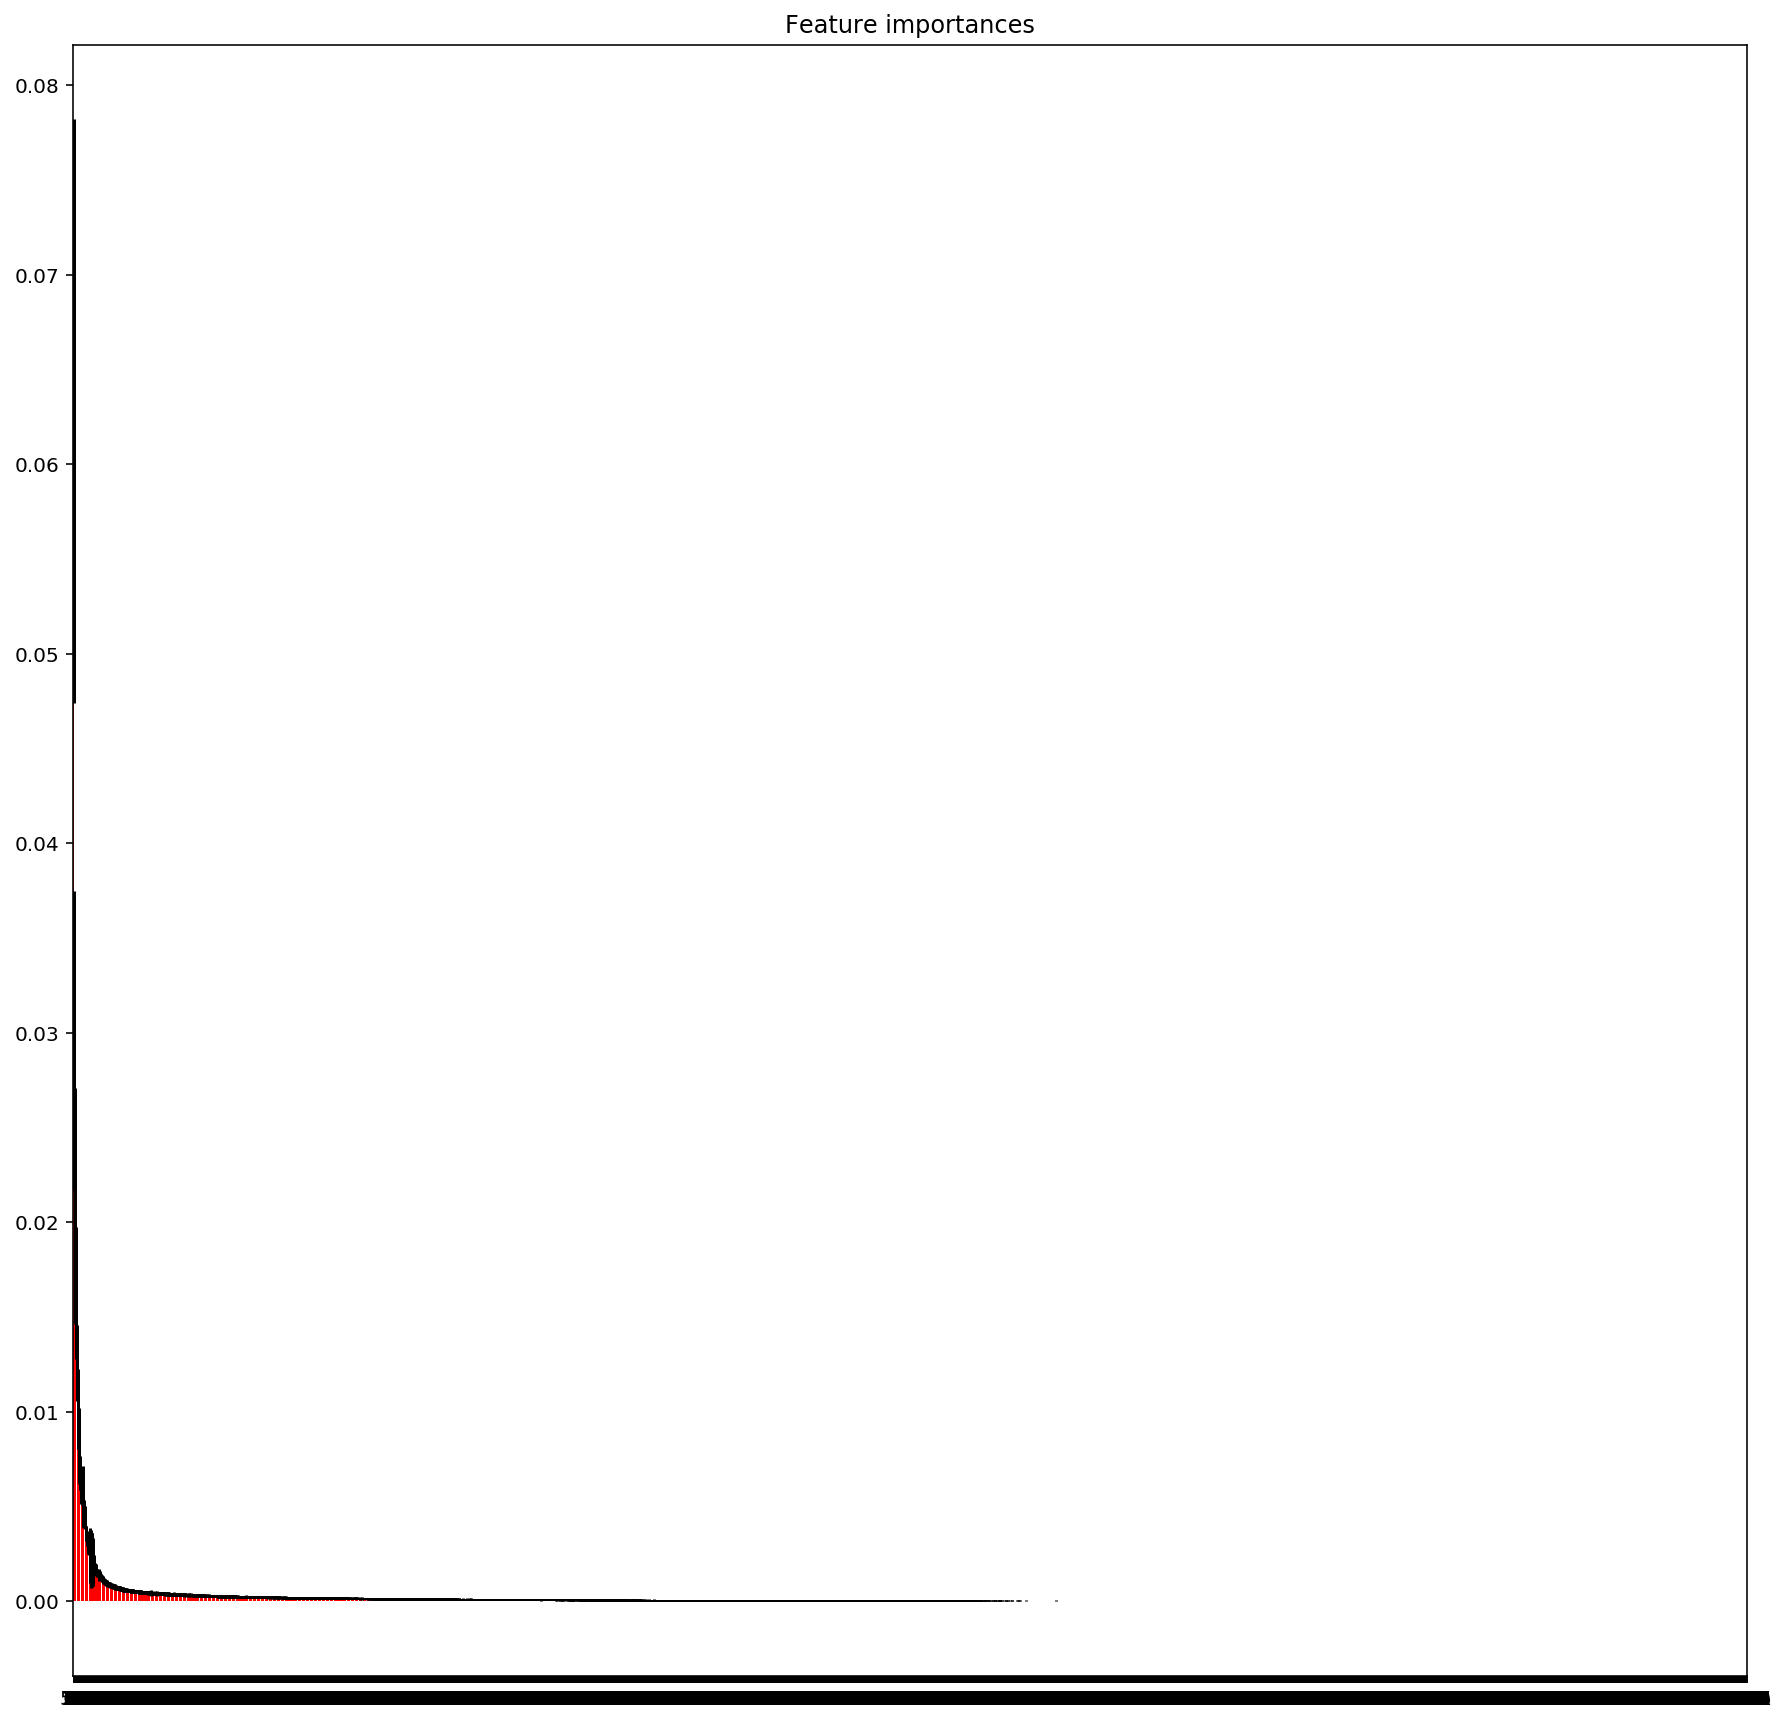

In [58]:
importances_forest_with_fineline = forest_with_fineline.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest_with_fineline.estimators_], axis=0)
indices = np.argsort(importances_forest_with_fineline)[::-1]

forest_feature_list = []
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances_forest_with_fineline[indices[f]]))
    forest_feature_list.append(X.columns[indices[f]])
    

plt.figure(figsize=(15,15))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances_forest_with_fineline[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [59]:
forest_feature_list = forest_feature_list[:1300]
X1_reduced = X1.loc[:,forest_feature_list]

In [60]:
X1_test_reduced = X1_test.loc[:,forest_feature_list]
X1_test_reduced.shape

(95674, 1300)

In [61]:
X1_reduced = pd.concat([X1_reduced, df_preprocessed[:95674]], axis=1)
print(X1_reduced.shape)
X1_reduced.head()

(95674, 2119)


,ScanCount,Return,FINANCIAL SERVICES,DSD GROCERY,GROCERY DRY GOODS,PHARMACY OTC,PERSONAL CARE,PRODUCE,DAIRY,SERVICE DELI,...,D_SPORTING GOODS_HARDWARE,D_SPORTING GOODS_BATH AND SHOWER,"D_SPORTING GOODS_GIRLS WEAR, 4-6X AND 7-14",D_SPORTING GOODS_HOME DECOR,D_HARDWARE_BATH AND SHOWER,"D_HARDWARE_GIRLS WEAR, 4-6X AND 7-14",D_HARDWARE_HOME DECOR,"D_BATH AND SHOWER_GIRLS WEAR, 4-6X AND 7-14",D_BATH AND SHOWER_HOME DECOR,"D_GIRLS WEAR, 4-6X AND 7-14_HOME DECOR"
0,-1.0,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,0.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,28.0,2.0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,0.0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,0.0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
X1_test_reduced = (np.hstack([np.array(X1_test_reduced), np.array(df_preprocessed[95674:])]))
X1_test_reduced.shape

(95674, 2119)

In [63]:
X1_test_reduced = pd.DataFrame(X1_test_reduced, columns=X1_reduced.columns)
X1_test_reduced.head()

,ScanCount,Return,FINANCIAL SERVICES,DSD GROCERY,GROCERY DRY GOODS,PHARMACY OTC,PERSONAL CARE,PRODUCE,DAIRY,SERVICE DELI,...,D_SPORTING GOODS_HARDWARE,D_SPORTING GOODS_BATH AND SHOWER,"D_SPORTING GOODS_GIRLS WEAR, 4-6X AND 7-14",D_SPORTING GOODS_HOME DECOR,D_HARDWARE_BATH AND SHOWER,"D_HARDWARE_GIRLS WEAR, 4-6X AND 7-14",D_HARDWARE_HOME DECOR,"D_BATH AND SHOWER_GIRLS WEAR, 4-6X AND 7-14",D_BATH AND SHOWER_HOME DECOR,"D_GIRLS WEAR, 4-6X AND 7-14_HOME DECOR"
0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
from imblearn.combine import *

In [65]:
X1_reduced_y0 = pd.concat([X1_reduced, y0], axis=1)
X1_reduced_y0.shape


(95674, 2120)

In [66]:
model_train_df, model_test_df = train_test_split(X1_reduced_y0, test_size = .3) 


In [67]:
y = model_train_df['TripType']
X = model_train_df.drop(['TripType'], axis=1)

test_X = model_test_df.drop(['TripType'], axis=1)
y_actual = model_test_df['TripType']

In [68]:
X1_reduced.shape

(95674, 2119)

In [69]:
forest_2120 = ExtraTreesClassifier(n_estimators=100, random_state=0, bootstrap=True ).fit(X,y)
y_hat = pd.Series(forest_2120.predict(test_X)).astype('float64')

In [70]:
confusion_matrix(y_actual, y_hat)

array([[1010,    0,    0, ...,    0,    0,   32],
       [   0,    1,   82, ...,    0,    0,    0],
       [   3,    4, 1157, ...,    0,    0,    3],
       ...,
       [   3,    0,   14, ...,    0,    0,    3],
       [   0,    0,    2, ...,    0,    2,    1],
       [ 187,    0,   39, ...,    0,    0, 2022]])

In [71]:
y_x_hat = pd.Series(forest_2120.predict(X)).astype('float64')

In [72]:
confusion_matrix(y, y_x_hat)

array([[2547,    0,    0, ...,    0,    0,    0],
       [   0,  249,    0, ...,    0,    0,    0],
       [   0,    0, 3168, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,  613,    0,    0],
       [   0,    0,    0, ...,    0,  837,    0],
       [   0,    0,    0, ...,    0,    0, 5811]])

In [73]:
print(classification_report(y, y_x_hat))

             precision    recall  f1-score   support

        3.0       1.00      1.00      1.00      2547
        4.0       1.00      1.00      1.00       249
        5.0       1.00      1.00      1.00      3168
        6.0       1.00      1.00      1.00       854
        7.0       1.00      1.00      1.00      4036
        8.0       1.00      1.00      1.00      8533
        9.0       1.00      1.00      1.00      6695
       12.0       1.00      1.00      1.00       192
       14.0       1.00      1.00      1.00         4
       15.0       1.00      1.00      1.00       675
       18.0       1.00      1.00      1.00       365
       19.0       1.00      1.00      1.00       267
       20.0       1.00      1.00      1.00       461
       21.0       1.00      1.00      1.00       435
       22.0       1.00      1.00      1.00       645
       23.0       1.00      1.00      1.00        96
       24.0       1.00      1.00      1.00      1844
       25.0       1.00      1.00      1.00   

In [74]:
print(classification_report(y_actual, y_hat))

             precision    recall  f1-score   support

        3.0       0.76      0.92      0.83      1096
        4.0       0.20      0.01      0.02        97
        5.0       0.73      0.81      0.77      1425
        6.0       0.68      0.65      0.66       423
        7.0       0.63      0.68      0.65      1716
        8.0       0.65      0.84      0.73      3628
        9.0       0.58      0.75      0.65      2769
       12.0       1.00      0.03      0.05        77
       15.0       0.69      0.30      0.42       303
       18.0       0.52      0.21      0.30       184
       19.0       0.29      0.11      0.16       108
       20.0       0.64      0.48      0.55       176
       21.0       0.62      0.44      0.52       206
       22.0       0.42      0.24      0.31       283
       23.0       0.57      0.09      0.16        43
       24.0       0.57      0.56      0.56       765
       25.0       0.66      0.70      0.68      1079
       26.0       0.50      0.18      0.26   

/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Feature ranking:
1. feature ScanCount (0.050254)
2. feature Return (0.029407)
3. feature FINANCIAL SERVICES (0.026037)
4. feature DSD GROCERY (0.021914)
5. feature GROCERY DRY GOODS (0.017268)
6. feature PHARMACY OTC (0.016450)
7. feature VisitNumber (0.016295)
8. feature PERSONAL CARE (0.016282)
9. feature PRODUCE (0.015797)
10. feature DAIRY (0.015450)
11. feature SERVICE DELI (0.014714)
12. feature PHARMACY RX (0.013261)
13. feature MENS WEAR (0.012387)
14. feature HOUSEHOLD CHEMICALS/SUPP (0.010705)
15. feature IMPULSE MERCHANDISE (0.009285)
16. feature INFANT CONSUMABLE HARDLINES (0.009111)
17. feature FROZEN FOODS (0.009004)
18. feature Num_Fineline_bought (0.007885)
19. feature Num_Upc_bought (0.007741)
20. feature scancount_mean (0.007608)
21. feature BEAUTY (0.007586)
22. feature HOUSEHOLD PAPER GOODS (0.007574)
23. feature COMM BREAD (0.007482)
24. feature Pct_F_D (0.007173)
25. feature scancount_max (0.007143)
26. feature Num_Department_bought (0.007008)
27. feature MEAT - F

1451. feature D_SERVICE DELI_PETS AND SUPPLIES (0.000106)
1452. feature 2250.0 (0.000106)
1453. feature D_PHARMACY OTC_INFANT APPAREL (0.000106)
1454. feature 715.0 (0.000106)
1455. feature 3602.0 (0.000106)
1456. feature D_Num_multi_pro_63 (0.000106)
1457. feature D_LADIESWEAR_HOME MANAGEMENT (0.000106)
1458. feature 7651.0 (0.000106)
1459. feature 9641.0 (0.000106)
1460. feature 4450.0 (0.000106)
1461. feature 1909.0 (0.000106)
1462. feature D_PETS AND SUPPLIES_COOK AND DINE (0.000106)
1463. feature 4520.0 (0.000106)
1464. feature D_HOUSEHOLD PAPER GOODS_LADIESWEAR (0.000106)
1465. feature 4009.0 (0.000105)
1466. feature D_PETS AND SUPPLIES_AUTOMOTIVE (0.000105)
1467. feature 5502.0 (0.000105)
1468. feature 1854.0 (0.000105)
1469. feature 7003.0 (0.000105)
1470. feature 9013.0 (0.000105)
1471. feature 271.0 (0.000105)
1472. feature 4406.0 (0.000105)
1473. feature 8905.0 (0.000105)
1474. feature 3324.0 (0.000105)
1475. feature 3103.0 (0.000105)
1476. feature 4202.0 (0.000105)
1477. fe

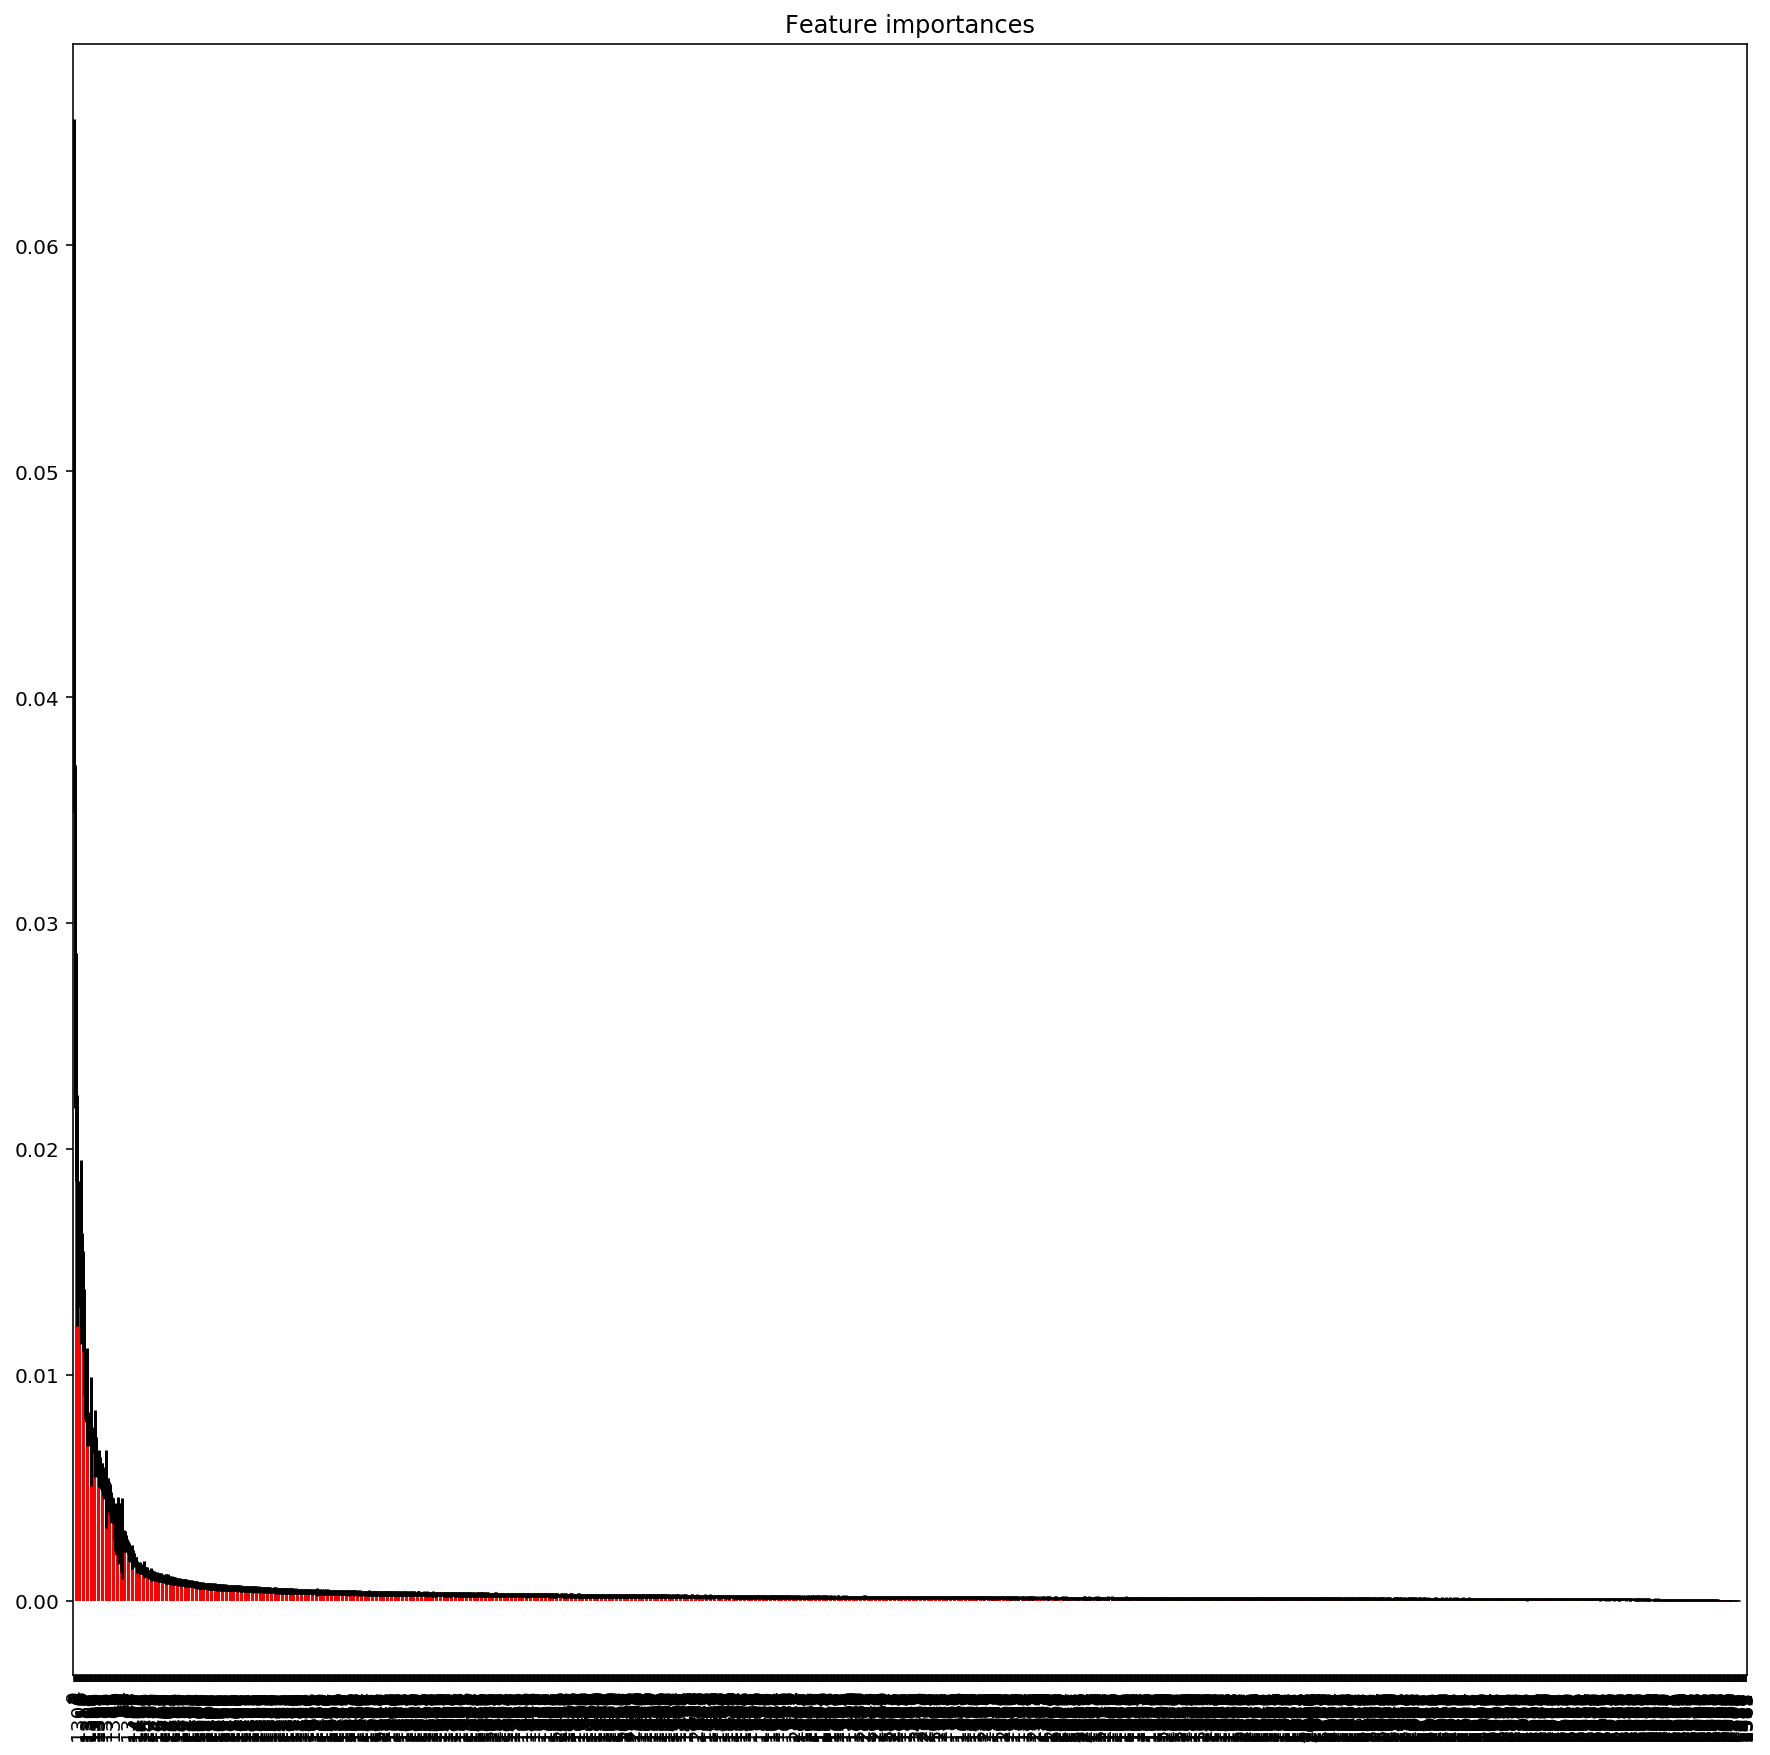

In [75]:
importances_forest_2120 = forest_2120.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest_2120.estimators_], axis=0)
indices = np.argsort(importances_forest_2120)[::-1]

forest_feature_list = []
print("Feature ranking:")
for f in range(X1_reduced.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X1_reduced.columns[indices[f]], importances_forest_2120[indices[f]]))
    forest_feature_list.append(X1_reduced.columns[indices[f]])
    

plt.figure(figsize=(15,15))
plt.title("Feature importances")
plt.bar(range(X1_reduced.shape[1]), importances_forest_2120[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X1_reduced.shape[1]), indices, rotation=90)
plt.xlim([-1, X1_reduced.shape[1]])
plt.show()

In [76]:
forest_feature_list = forest_feature_list[:1000]
X1_1000 = X1_reduced.loc[:,forest_feature_list]
print(X1_1000.shape)
X1_test_1000 = X1_test_reduced.loc[:,forest_feature_list]
X1_test_1000.shape

(95674, 1000)


(95674, 1000)

In [77]:
# X1_1000.to_csv('X1_1000_final.csv', index=False)
# X1_test_1000.to_csv('X1_test_1000.csv', index=False)

In [78]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y0)
le.classes_

array([  3.,   4.,   5.,   6.,   7.,   8.,   9.,  12.,  14.,  15.,  18.,
        19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,
        30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,
        41.,  42.,  43.,  44., 999.])

In [79]:
y0_encoded = le.transform(y0) 
y0_encoded

array([37, 22, 18, ..., 31, 31,  5])

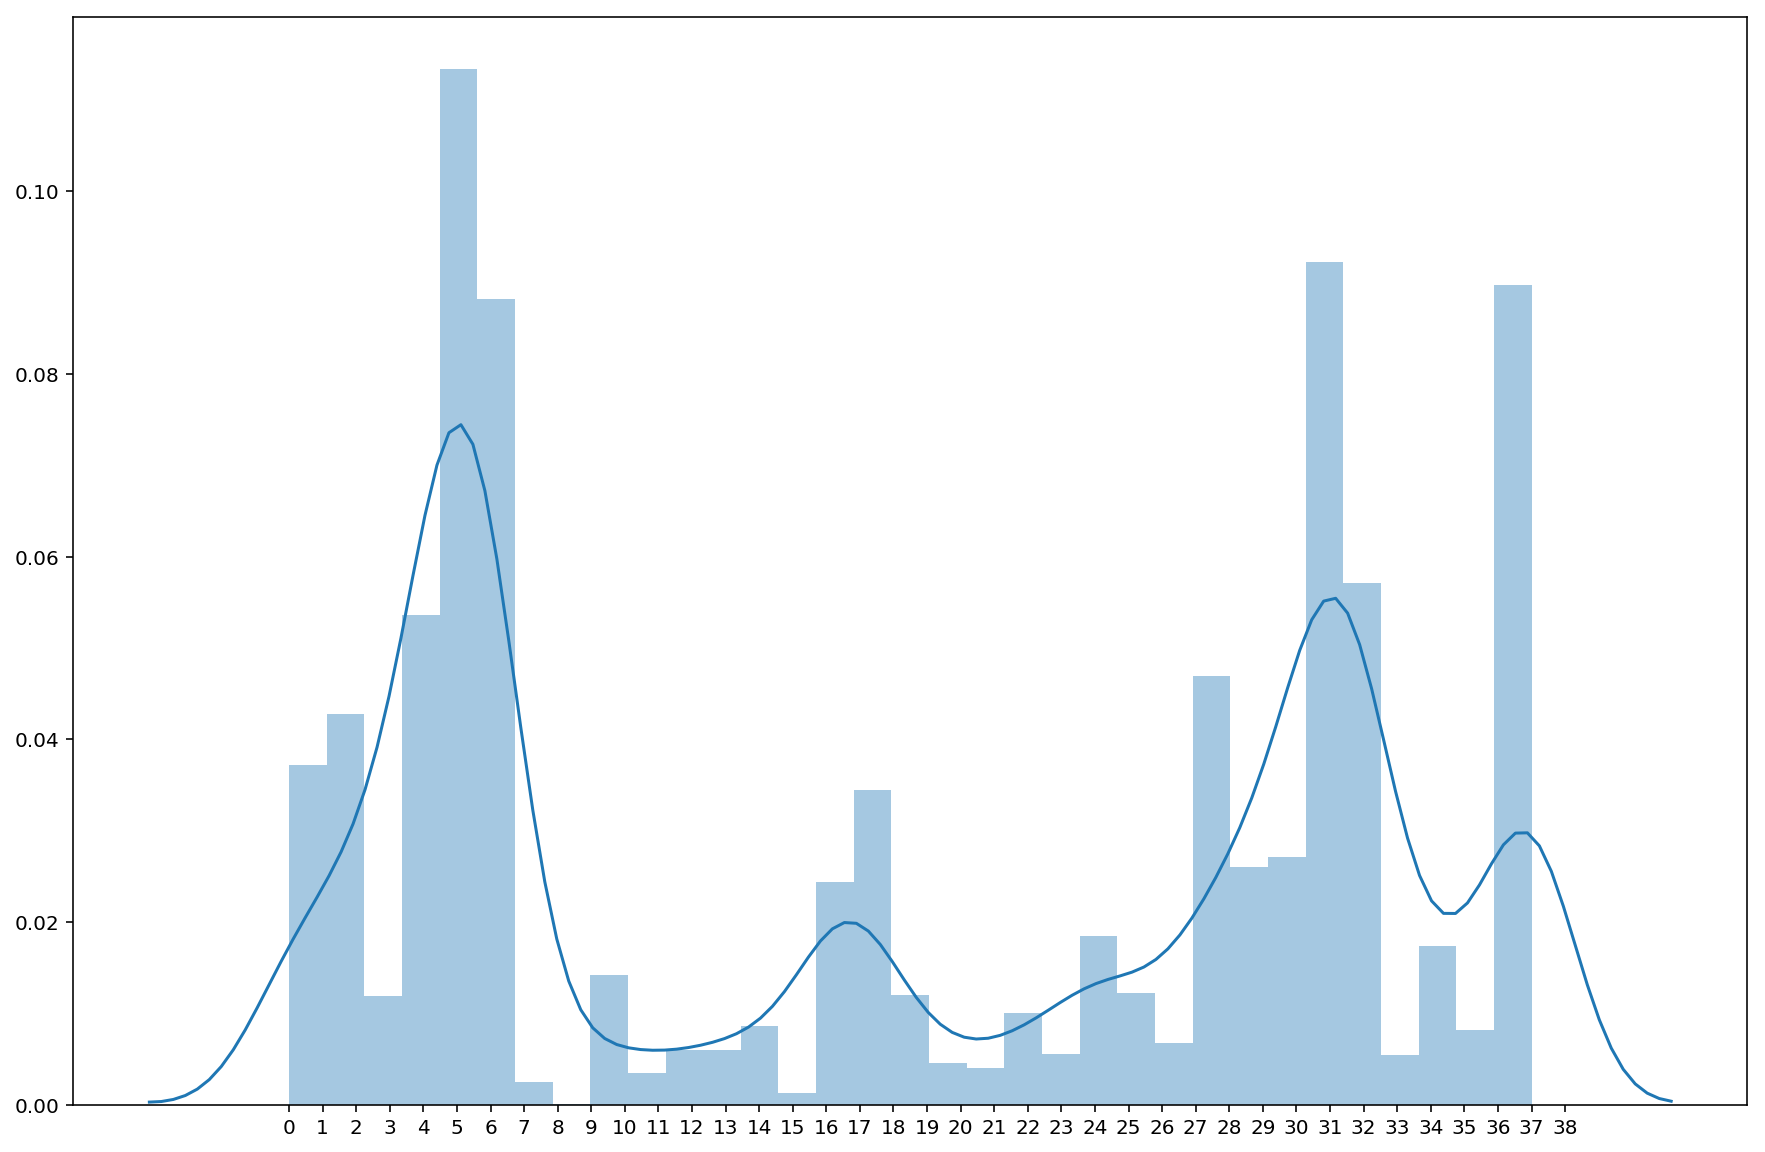

In [80]:
plt.figure(figsize=(15,10))
sns.distplot(y0_encoded)
plt.xticks(range(0,39))
plt.show()

In [81]:
# X1_1000 = pd.read_csv('X1_1000_final.csv')
# X1_test_1000 = pd.read_csv('X1_test_1000.csv')

In [38]:
import lightgbm as lgb


In [83]:
# X1_1000.drop('Unnamed: 0', axis = 1, inplace=True)
# X1_1000.head()

In [84]:
# X1_test_1000.drop('Unnamed: 0', axis = 1, inplace=True)
# X1_test_1000.head()

In [85]:
from collections import Counter
print(Counter(y0)) #  14.0: 4
y0[y0==14.0]

Counter({8.0: 12161, 39.0: 9896, 9.0: 9464, 999.0: 8444, 40.0: 6130, 7.0: 5752, 5.0: 4593, 25.0: 3698, 3.0: 3643, 36.0: 3005, 38.0: 2912, 37.0: 2788, 24.0: 2609, 35.0: 2030, 32.0: 1984, 42.0: 1858, 33.0: 1315, 6.0: 1277, 44.0: 1187, 30.0: 1081, 15.0: 978, 22.0: 928, 43.0: 872, 27.0: 785, 34.0: 719, 21.0: 641, 20.0: 637, 31.0: 594, 41.0: 583, 18.0: 549, 26.0: 503, 28.0: 492, 29.0: 433, 19.0: 375, 4.0: 346, 12.0: 269, 23.0: 139, 14.0: 4})


1099     14.0
6168     14.0
12546    14.0
27385    14.0
Name: TripType, dtype: category
Categories (38, float64): [3.0, 4.0, 5.0, 6.0, ..., 42.0, 43.0, 44.0, 999.0]

In [86]:
X1_1000.shape

(95674, 1000)

In [87]:
X1_14_for_oversampling = X1_1000.iloc[[1099,6168,12546,27385],:]
X1_1000_14 = pd.concat([X1_1000, X1_14_for_oversampling])
X1_1000_14.shape

(95678, 1000)

In [88]:

y0_14 = pd.concat([y0,(pd.Series([14.0,14.0,14.0,14.0], index=[95674,95675,95676,95677]))])

In [89]:
from imblearn.over_sampling import *


X1_oversampled, y_oversampled = SMOTE(ratio='minority', random_state=0).fit_sample(X1_1000_14, y0_14)
X1_oversampled.shape, y_oversampled.shape

((107831, 1000), (107831,))

In [90]:
len(y_oversampled[y_oversampled==14.0]) #12161
idx_oversampled = np.random.randint(12161, size = (300))

In [91]:
y_14 = (y_oversampled[y_oversampled==14.0])[idx_oversampled]
y_14.shape

(300,)

In [92]:
x1_14 = ((X1_oversampled[y_oversampled==14.0])[idx_oversampled])
x1_14.shape

(300, 1000)

In [93]:
###### (X1_oversampled[y_oversampled != 14.0]).shape , (y_oversampled[y_oversampled != 14.0]).shape
X1_oversampled = X1_oversampled[y_oversampled != 14.0]
y_oversampled = y_oversampled[y_oversampled != 14.0]
X1_oversampled.shape, y_oversampled.shape

((95670, 1000), (95670,))

In [94]:
X1_oversampled_14 = pd.DataFrame(np.vstack([X1_oversampled,x1_14]), columns=X1_1000.columns)
# X1_oversampled_14.tail(305)
y_oversampled_14 = pd.Series(np.hstack([y_oversampled,y_14]), index = range(95970))
y_oversampled_14[-305:]

95665    25.0
95666    22.0
95667    39.0
95668    39.0
95669     8.0
95670    14.0
95671    14.0
95672    14.0
95673    14.0
95674    14.0
95675    14.0
95676    14.0
95677    14.0
95678    14.0
95679    14.0
95680    14.0
95681    14.0
95682    14.0
95683    14.0
95684    14.0
95685    14.0
95686    14.0
95687    14.0
95688    14.0
95689    14.0
95690    14.0
95691    14.0
95692    14.0
95693    14.0
95694    14.0
         ... 
95940    14.0
95941    14.0
95942    14.0
95943    14.0
95944    14.0
95945    14.0
95946    14.0
95947    14.0
95948    14.0
95949    14.0
95950    14.0
95951    14.0
95952    14.0
95953    14.0
95954    14.0
95955    14.0
95956    14.0
95957    14.0
95958    14.0
95959    14.0
95960    14.0
95961    14.0
95962    14.0
95963    14.0
95964    14.0
95965    14.0
95966    14.0
95967    14.0
95968    14.0
95969    14.0
Length: 305, dtype: float64

In [96]:
# X1_oversampled_14.to_csv('X1_oversampled_14.csv', index=False)
# y_oversampled_14.to_csv('y_oversampled_14.csv', index=False)
# X1_test_1000.to_csv('X1_test_1000.csv',index=False)

In [129]:
X1_oversampled_14 = pd.read_csv('X1_oversampled_14.csv')
X1_test_1000 = pd.read_csv('X1_test_1000.csv')

In [130]:
y0.shape
y_oversampled_14 = y0[y0!=14.0]
y_oversampled_14.shape
y_oversampled_14 = pd.Series(np.hstack([np.array(y_oversampled_14),np.array([14.0]*300)]), index = range(95970))
y_oversampled_14

0        999.0
1         30.0
2         26.0
3          8.0
4          8.0
5         35.0
6         41.0
7         21.0
8          6.0
9         42.0
10         7.0
11         9.0
12         8.0
13        39.0
14        25.0
15         8.0
16         9.0
17         8.0
18         8.0
19         8.0
20         8.0
21         8.0
22         8.0
23        38.0
24         8.0
25        35.0
26        15.0
27         9.0
28         8.0
29         8.0
         ...  
95940     14.0
95941     14.0
95942     14.0
95943     14.0
95944     14.0
95945     14.0
95946     14.0
95947     14.0
95948     14.0
95949     14.0
95950     14.0
95951     14.0
95952     14.0
95953     14.0
95954     14.0
95955     14.0
95956     14.0
95957     14.0
95958     14.0
95959     14.0
95960     14.0
95961     14.0
95962     14.0
95963     14.0
95964     14.0
95965     14.0
95966     14.0
95967     14.0
95968     14.0
95969     14.0
Length: 95970, dtype: float64

In [131]:
X1_oversampled_y_oversampled = pd.concat([X1_oversampled_14, y_oversampled_14], axis=1)
X1_oversampled_y_oversampled.shape

(95970, 1001)

In [132]:
X1_oversampled_y_oversampled = X1_oversampled_y_oversampled.rename(columns={0:'TripType'})
X1_oversampled_y_oversampled.head()

,ScanCount,Return,FINANCIAL SERVICES,DSD GROCERY,GROCERY DRY GOODS,PHARMACY OTC,VisitNumber,PERSONAL CARE,PRODUCE,DAIRY,...,D_HOUSEHOLD CHEMICALS/SUPP_CELEBRATION,5001.0,5414.0,9926.0,3809.0,3509.0,9014.0,1020.0,D_PHARMACY OTC_HOME DECOR,TripType
0,-1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,999.0
1,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
2,28.0,2.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0
3,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,3.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0


In [133]:
model_train_df, model_test_df = train_test_split(X1_oversampled_y_oversampled, test_size = .3) 
y = model_train_df['TripType']
X = model_train_df.drop(['TripType'], axis=1)

test_X = model_test_df.drop(['TripType'], axis=1)
y_actual = model_test_df['TripType']

In [134]:
forest_14_oversampled = ExtraTreesClassifier(n_estimators=100, random_state=0).fit(X, y)
y_hat = pd.Series(forest_14_oversampled.predict(test_X)).astype('float64')

In [135]:
print(confusion_matrix(y_actual, y_hat))
y_x_hat = pd.Series(forest_14_oversampled.predict(X)).astype('float64')

[[1014    0    0 ...    0    0   64]
 [   0    5   95 ...    0    0    1]
 [   6    3 1113 ...    0    0   11]
 ...
 [   6    0   10 ...    1    0    3]
 [   1    0    2 ...    0    3    1]
 [ 198    0   26 ...    0    0 2014]]


In [136]:
confusion_matrix(y, y_x_hat)

array([[2502,    0,    0, ...,    0,    0,    0],
       [   0,  223,    0, ...,    0,    0,    0],
       [   0,    0, 3231, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,  602,    0,    0],
       [   0,    0,    0, ...,    0,  842,    0],
       [   0,    0,    0, ...,    0,    0, 5841]])

In [137]:
print(classification_report(y, y_x_hat))

             precision    recall  f1-score   support

        3.0       1.00      1.00      1.00      2502
        4.0       1.00      1.00      1.00       223
        5.0       1.00      1.00      1.00      3231
        6.0       1.00      1.00      1.00       913
        7.0       1.00      1.00      1.00      4059
        8.0       1.00      1.00      1.00      8491
        9.0       1.00      1.00      1.00      6641
       12.0       1.00      1.00      1.00       184
       14.0       1.00      1.00      1.00       216
       15.0       1.00      1.00      1.00       684
       18.0       1.00      1.00      1.00       375
       19.0       1.00      1.00      1.00       270
       20.0       1.00      1.00      1.00       443
       21.0       1.00      1.00      1.00       463
       22.0       1.00      1.00      1.00       660
       23.0       1.00      1.00      1.00        94
       24.0       1.00      1.00      1.00      1845
       25.0       1.00      1.00      1.00   

In [138]:
print(classification_report(y_actual, y_hat))

             precision    recall  f1-score   support

        3.0       0.77      0.89      0.82      1141
        4.0       0.62      0.04      0.08       123
        5.0       0.72      0.82      0.76      1362
        6.0       0.69      0.68      0.68       364
        7.0       0.63      0.66      0.65      1693
        8.0       0.70      0.85      0.77      3670
        9.0       0.62      0.74      0.67      2823
       12.0       0.00      0.00      0.00        85
       14.0       1.00      1.00      1.00        84
       15.0       0.61      0.32      0.42       294
       18.0       0.54      0.30      0.38       174
       19.0       0.32      0.23      0.27       105
       20.0       0.72      0.48      0.58       194
       21.0       0.63      0.53      0.58       178
       22.0       0.44      0.23      0.30       268
       23.0       0.25      0.13      0.17        45
       24.0       0.63      0.59      0.61       764
       25.0       0.62      0.75      0.68   

Feature ranking:
1. feature ScanCount (0.062698)
2. feature Return (0.032740)
3. feature FINANCIAL SERVICES (0.026219)
4. feature DSD GROCERY (0.024397)
5. feature VisitNumber (0.020801)
6. feature GROCERY DRY GOODS (0.020177)
7. feature PERSONAL CARE (0.018783)
8. feature PHARMACY OTC (0.018702)
9. feature PRODUCE (0.017181)
10. feature DAIRY (0.016304)
11. feature SERVICE DELI (0.015666)
12. feature MENS WEAR (0.013509)
13. feature PHARMACY RX (0.013385)
14. feature HOUSEHOLD CHEMICALS/SUPP (0.011447)
15. feature IMPULSE MERCHANDISE (0.010442)
16. feature INFANT CONSUMABLE HARDLINES (0.010144)
17. feature Num_Fineline_bought (0.009795)
18. feature Num_Upc_bought (0.009593)
19. feature FROZEN FOODS (0.009206)
20. feature scancount_mean (0.008986)
21. feature HOUSEHOLD PAPER GOODS (0.008923)
22. feature Pct_F_D (0.008680)
23. feature BEAUTY (0.008658)
24. feature Num_Department_bought (0.008642)
25. feature scancount_max (0.008560)
26. feature COMM BREAD (0.008284)
27. feature Pct_U_D 

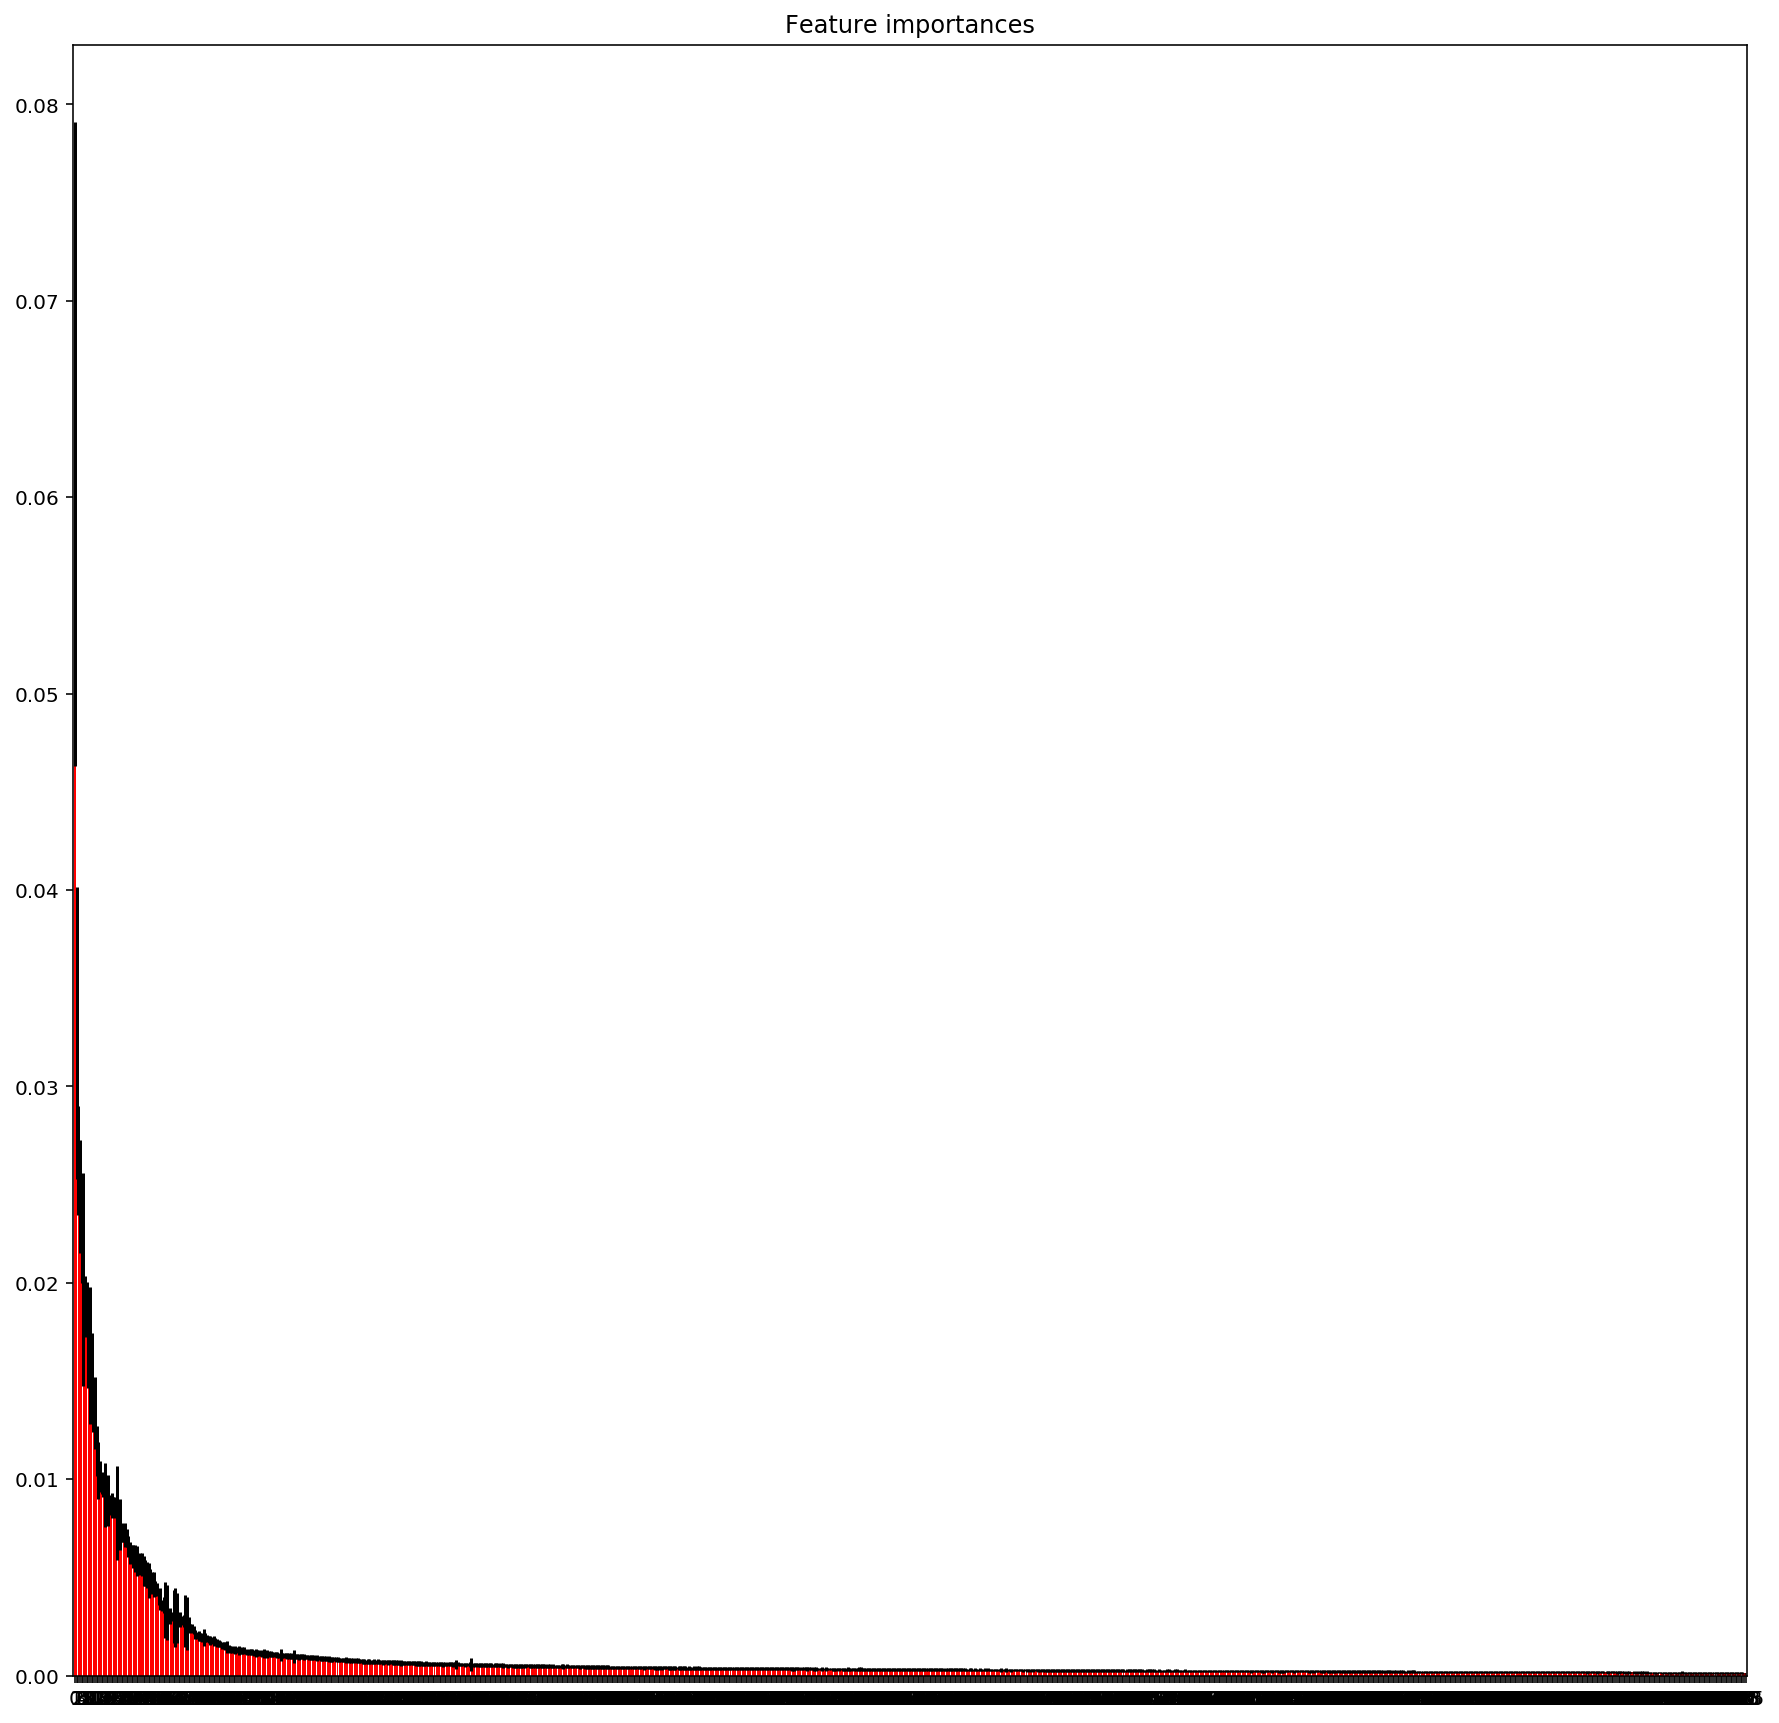

In [139]:
importances_forest_14_oversampled = forest_14_oversampled.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest_14_oversampled.estimators_], axis=0)
indices = np.argsort(importances_forest_14_oversampled)[::-1]

forest_feature_list = []
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1,X.columns[indices[f]], importances_forest_14_oversampled[indices[f]]))
    forest_feature_list.append(X.columns[indices[f]])
    

plt.figure(figsize=(15,15))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances_forest_14_oversampled[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [140]:
forest_feature_list1 = forest_feature_list[:300]
X1_reduced1 = X1_oversampled_14.loc[:,forest_feature_list1]
print(X1_reduced1.shape)
X1_test_reduced1 = X1_test_1000.loc[:,forest_feature_list1]
X1_test_reduced1.shape

(95970, 300)


(95674, 300)

In [141]:
forest_feature_list2 = forest_feature_list[:400]
X1_reduced2 = X1_oversampled_14.loc[:,forest_feature_list2]
X1_reduced2.tail()
X1_test_reduced2 = X1_test_1000.loc[:,forest_feature_list2]
X1_test_reduced2.shape

(95674, 400)

In [142]:
forest_feature_list3 = forest_feature_list[:500]
X1_reduced3 = X1_oversampled_14.loc[:,forest_feature_list3]
X1_reduced3.tail()
X1_test_reduced3 = X1_test_1000.loc[:,forest_feature_list3]
X1_test_reduced3.shape

(95674, 500)

In [143]:
forest_feature_list4 = forest_feature_list[:600]
X1_reduced4 = X1_oversampled_14.loc[:,forest_feature_list4]
X1_reduced4.head()
X1_test_reduced4 = X1_test_1000.loc[:,forest_feature_list4]
X1_test_reduced4.shape

(95674, 600)

In [144]:
forest_feature_list5 = forest_feature_list[:700]
X1_reduced5 = X1_oversampled_14.loc[:,forest_feature_list5]
X1_reduced5.head()
X1_test_reduced5 = X1_test_1000.loc[:,forest_feature_list5]
X1_test_reduced5.shape

(95674, 700)

In [145]:
forest_feature_list5 = forest_feature_list[:700]
X1_reduced5_1 = X1_oversampled_14.loc[:,forest_feature_list5]
X1_reduced5_1.head()
X1_test_reduced5_1 = X1_test_1000.loc[:,forest_feature_list5]
X1_test_reduced5_1.shape

(95674, 700)

In [146]:
forest_feature_list6 = forest_feature_list[:800]
X1_reduced6 = X1_oversampled_14.loc[:,forest_feature_list6]
X1_reduced6.head()
X1_test_reduced6 = X1_test_1000.loc[:,forest_feature_list6]
X1_test_reduced6.shape

(95674, 800)

In [147]:
forest_feature_list7 = forest_feature_list[:900]
X1_reduced7 = X1_oversampled_14.loc[:,forest_feature_list7]
X1_reduced7.head()
X1_test_reduced7 = X1_test_1000.loc[:,forest_feature_list7]
X1_test_reduced7.shape

(95674, 900)

In [148]:
forest_feature_list8 = forest_feature_list[:1000]
X1_reduced8 = X1_oversampled_14.loc[:,forest_feature_list8]
X1_reduced8.head()
X1_test_reduced8 = X1_test_1000.loc[:,forest_feature_list8]
X1_test_reduced8.shape

(95674, 1000)

In [149]:
X1_reduced_data_list = [X1_reduced1,X1_reduced2,X1_reduced3,X1_reduced4,X1_reduced5,\
                        X1_reduced6,X1_reduced7,X1_reduced8]

In [150]:
# d=1
# for i in X1_reduced_data_list:
#     i.to_csv('x1_reduced_%d.csv'%d, index=False)
#     d += 1

In [152]:
y0.shape
y_oversampled_14 = y0[y0!=14.0]
y_oversampled_14.shape
y_oversampled_14 = pd.Series(np.hstack([np.array(y_oversampled_14),np.array([14.0]*300)]), index = range(95970))
y_oversampled_14

0        999.0
1         30.0
2         26.0
3          8.0
4          8.0
5         35.0
6         41.0
7         21.0
8          6.0
9         42.0
10         7.0
11         9.0
12         8.0
13        39.0
14        25.0
15         8.0
16         9.0
17         8.0
18         8.0
19         8.0
20         8.0
21         8.0
22         8.0
23        38.0
24         8.0
25        35.0
26        15.0
27         9.0
28         8.0
29         8.0
         ...  
95940     14.0
95941     14.0
95942     14.0
95943     14.0
95944     14.0
95945     14.0
95946     14.0
95947     14.0
95948     14.0
95949     14.0
95950     14.0
95951     14.0
95952     14.0
95953     14.0
95954     14.0
95955     14.0
95956     14.0
95957     14.0
95958     14.0
95959     14.0
95960     14.0
95961     14.0
95962     14.0
95963     14.0
95964     14.0
95965     14.0
95966     14.0
95967     14.0
95968     14.0
95969     14.0
Length: 95970, dtype: float64

# 모형 최적화

In [153]:
from sklearn.model_selection import cross_val_score

def logloss_cv(model, X1_reduced3):
    
    logloss = (-cross_val_score(model, X1_reduced3, y_oversampled_14, scoring="neg_log_loss", cv = 5))
    return(logloss)

In [154]:
def change_dtype(l, dtype=int):
    return map(dtype, l)

In [155]:
from sklearn.preprocessing import StandardScaler

def determine_best_lgb(X1_reduced_data_list, param_range_range):
    cv_lgb_list = []
    for X1_reduced_train in X1_reduced_data_list:
        scaler = StandardScaler()
        X1_reduced_train = scaler.fit_transform(X1_reduced_train)
#         X1_reduced_test = scaler.fit_transform(X1_test_reduced1)
        cv_lgb = [logloss_cv(lgb.LGBMClassifier(n_estimators=i,sub_row=0.8, subsample=0.8, subsample_freq=1)).mean() 
            for i in param_range]
        cv_lgb_list.append(cv_lgb)
        print('--')
    return cv_lgb_list
    


In [156]:
param_range = np.linspace(3,3,1)
# param_range = list(change_dtype(param_range))
param_range

array([3.])

In [157]:
# cv_lgb = [logloss_cv(lgb.LGBMClassifier(n_estimators=100, reg_lambda=10*i),X1_reduced6).mean() 
#             for i in param_range]

In [158]:
# min_lgb = min(cv_lgb)
# min_index = cv_lgb.index(min_lgb)

In [159]:
# min_lgb, min_index

In [160]:
# cv_lgb

In [161]:
# plt.figure(figsize=(8, 6))
# plt.semilogx(10.0**alphas, (cv_lasso), label='Lasso: Train')

# plt.xlabel('$\lambda$')
# plt.ylabel(r'$RMSE$')

# plt.grid()
# plt.legend(loc = 'best')

# plt.show()
# print('min RMSE on training set', min(cv_lasso))

## Best-fit-model Validation



In [162]:
# n_estimators = param_range[min_index]
# n_estimators

In [163]:
X1_reduced_train = X1_reduced6
X1_reduced_test = X1_test_reduced6

In [164]:
X1_reduced_train.shape
X1_reduced_test.shape

(95674, 800)

In [165]:
X1_reduced_train_y_oversampled_14 = pd.concat([X1_reduced_train, y_oversampled_14], axis=1)
X1_reduced_train_y_oversampled_14 = X1_reduced_train_y_oversampled_14.rename(columns={0:'TripType'})
X1_reduced_train_y_oversampled_14.head()
model_train_df, model_test_df = train_test_split(X1_reduced_train_y_oversampled_14, test_size = .3) 
 

In [166]:
model_train_df.head()

,ScanCount,Return,FINANCIAL SERVICES,DSD GROCERY,VisitNumber,GROCERY DRY GOODS,PHARMACY OTC,PERSONAL CARE,PRODUCE,DAIRY,...,D_Neg_pro_16,D_HOUSEHOLD CHEMICALS/SUPP_SHOES,6425.0,"D_CANDY, TOBACCO, COOKIES_BAKERY",1265.0,4253.0,1344.0,6113.0,D_SERVICE DELI_PRE PACKED DELI,TripType
2230,1.0,0.0,0.0,0.0,2232.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
67096,47.0,0.0,0.0,4.0,67101.0,0.0,1.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
37198,7.0,0.0,0.0,1.0,37203.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0
77318,11.0,0.0,0.0,3.0,77323.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
62590,1.0,0.0,0.0,0.0,62595.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0


In [167]:
y = model_train_df['TripType']
X = model_train_df.drop(['TripType'], axis=1)

test_X = model_test_df.drop(['TripType'], axis=1)
y_actual = model_test_df['TripType']

In [168]:
lgb_best_model_validation = lgb.LGBMClassifier(n_estimators=100, reg_alpha=1.5).fit(X, y)
y_hat = pd.Series(lgb_best_model_validation.predict(test_X)).astype('float64')


/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [169]:
print(confusion_matrix(y_actual, y_hat))
y_x_hat = pd.Series(lgb_best_model_validation.predict(X)).astype('float64')

[[1016    0    0 ...    0    0    1]
 [   0    0   97 ...    0    0    0]
 [   2    2 1109 ...    0    0    0]
 ...
 [   0    0   12 ...    9    3    0]
 [   0    0    1 ...    2   53    0]
 [ 217    0   23 ...    0    0 1910]]


/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [170]:
confusion_matrix(y, y_x_hat)

array([[2590,    0,    1, ...,    0,    0,    0],
       [   0,   55,  146, ...,    0,    0,    0],
       [   1,    0, 2895, ...,    1,    3,    2],
       ...,
       [   0,    0,   13, ...,  190,    5,    0],
       [   0,    0,    2, ...,    1,  506,    0],
       [ 455,    0,   57, ...,    1,    1, 4519]])

In [171]:
print(classification_report(y, y_x_hat))

             precision    recall  f1-score   support

        3.0       0.81      0.99      0.89      2604
        4.0       1.00      0.24      0.38       233
        5.0       0.81      0.89      0.85      3235
        6.0       0.81      0.82      0.82       878
        7.0       0.77      0.73      0.75      4023
        8.0       0.82      0.89      0.85      8533
        9.0       0.77      0.85      0.81      6590
       12.0       0.94      0.56      0.71       193
       14.0       1.00      1.00      1.00       216
       15.0       0.79      0.58      0.67       692
       18.0       0.76      0.67      0.71       378
       19.0       0.88      0.68      0.77       260
       20.0       0.86      0.84      0.85       461
       21.0       0.82      0.84      0.83       467
       22.0       0.72      0.69      0.70       658
       23.0       0.79      0.65      0.71       101
       24.0       0.73      0.75      0.74      1828
       25.0       0.77      0.88      0.82   

In [172]:
print(classification_report(y_actual, y_hat))

             precision    recall  f1-score   support

        3.0       0.74      0.98      0.84      1039
        4.0       0.00      0.00      0.00       113
        5.0       0.74      0.82      0.77      1358
        6.0       0.73      0.69      0.71       399
        7.0       0.70      0.65      0.67      1729
        8.0       0.78      0.86      0.82      3628
        9.0       0.70      0.80      0.75      2874
       12.0       0.30      0.12      0.17        76
       14.0       1.00      1.00      1.00        84
       15.0       0.63      0.42      0.50       286
       18.0       0.45      0.41      0.43       171
       19.0       0.30      0.18      0.23       115
       20.0       0.58      0.53      0.56       176
       21.0       0.55      0.60      0.57       174
       22.0       0.41      0.37      0.39       270
       23.0       0.41      0.32      0.36        38
       24.0       0.58      0.62      0.60       781
       25.0       0.70      0.77      0.73   

### 최적화한 reg_alpha

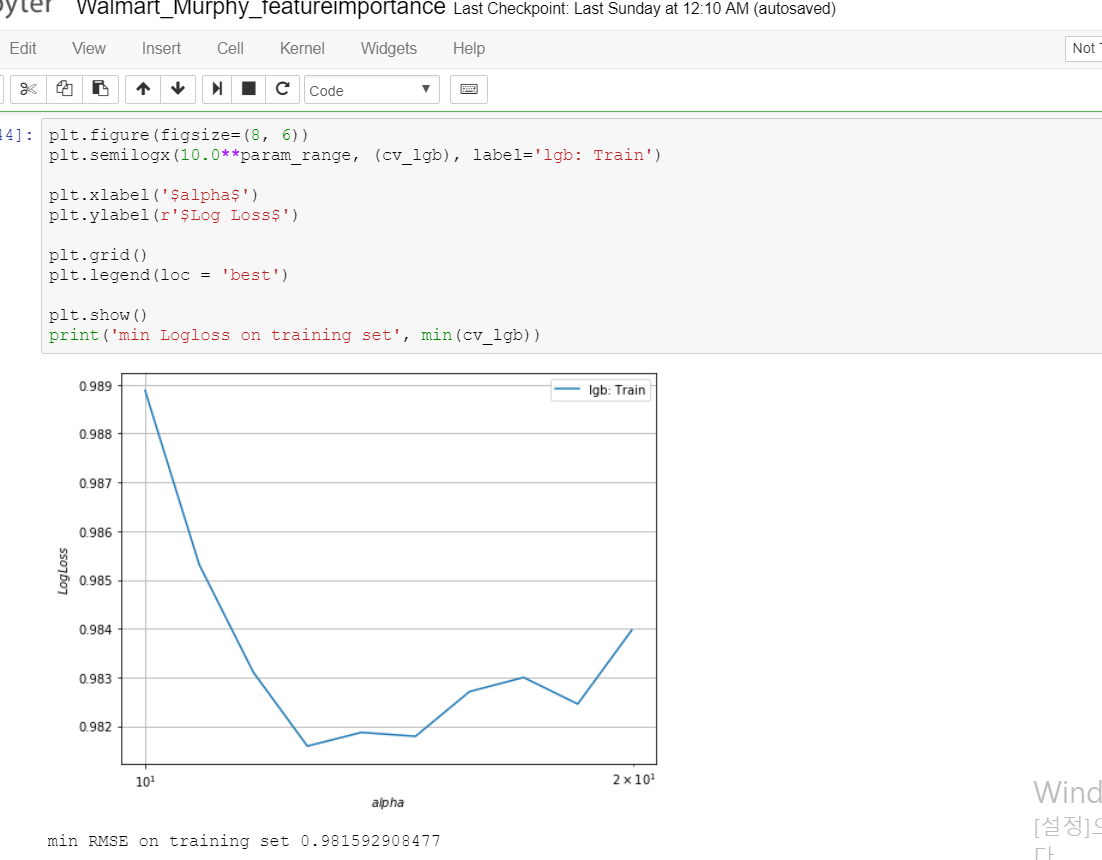

In [173]:
from PIL import Image as pil
pil.open('reg_alpha_optimisation.png')

In [174]:
lgb_best_model_validation = lgb.LGBMClassifier(n_estimators=100, reg_alpha=10**1.1).fit(X, y)
y_hat = pd.Series(lgb_best_model_validation.predict(test_X)).astype('float64')


/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [175]:
print(confusion_matrix(y_actual, y_hat))
y_x_hat = pd.Series(lgb_best_model_validation.predict(X)).astype('float64')

[[1020    0    0 ...    0    0    0]
 [   0    0  100 ...    0    0    0]
 [   3    0 1112 ...    0    0    0]
 ...
 [   0    0    9 ...    1    3    0]
 [   0    0    3 ...    0   40    0]
 [ 219    0   22 ...    0    0 1902]]


/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [176]:
confusion_matrix(y, y_x_hat)

array([[2577,    0,    0, ...,    0,    0,    0],
       [   0,    0,  200, ...,    0,    0,    1],
       [   1,    0, 2801, ...,    0,    2,    1],
       ...,
       [   0,    0,   24, ...,   11,    8,    0],
       [   0,    0,    3, ...,    0,  261,    0],
       [ 490,    0,   54, ...,    1,    1, 4417]])

In [177]:
print(classification_report(y, y_x_hat))

             precision    recall  f1-score   support

        3.0       0.79      0.99      0.88      2604
        4.0       0.00      0.00      0.00       233
        5.0       0.76      0.87      0.81      3235
        6.0       0.71      0.76      0.73       878
        7.0       0.72      0.69      0.71      4023
        8.0       0.79      0.87      0.83      8533
        9.0       0.71      0.79      0.75      6590
       12.0       0.64      0.14      0.23       193
       14.0       1.00      0.97      0.99       216
       15.0       0.69      0.46      0.55       692
       18.0       0.51      0.44      0.47       378
       19.0       0.48      0.17      0.25       260
       20.0       0.67      0.66      0.66       461
       21.0       0.70      0.72      0.71       467
       22.0       0.51      0.41      0.45       658
       23.0       0.52      0.29      0.37       101
       24.0       0.63      0.67      0.65      1828
       25.0       0.71      0.82      0.76   

/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [178]:
print(classification_report(y_actual, y_hat))

             precision    recall  f1-score   support

        3.0       0.74      0.98      0.84      1039
        4.0       0.00      0.00      0.00       113
        5.0       0.73      0.82      0.77      1358
        6.0       0.70      0.70      0.70       399
        7.0       0.68      0.64      0.66      1729
        8.0       0.77      0.86      0.81      3628
        9.0       0.69      0.79      0.74      2874
       12.0       0.20      0.04      0.07        76
       14.0       1.00      0.96      0.98        84
       15.0       0.66      0.42      0.51       286
       18.0       0.42      0.36      0.39       171
       19.0       0.44      0.16      0.23       115
       20.0       0.58      0.52      0.54       176
       21.0       0.54      0.58      0.56       174
       22.0       0.42      0.33      0.37       270
       23.0       0.35      0.16      0.22        38
       24.0       0.57      0.60      0.59       781
       25.0       0.70      0.78      0.74   

/Users/doyoung/.pyenv/versions/anaconda3-5.0.0/envs/dodo/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Best-fit-model

In [179]:
lgb_best_model = lgb.LGBMClassifier(n_estimators=100, reg_alpha=10**1.11).fit(X1_reduced_train, y_oversampled_14)


## Insight

Feature ranking:
1. feature ScanCount (10216.000000)
2. feature VisitNumber (5021.000000)
3. feature PHARMACY OTC (1929.000000)
4. feature DSD GROCERY (1895.000000)
5. feature PRODUCE (1874.000000)
6. feature PERSONAL CARE (1867.000000)
7. feature GROCERY DRY GOODS (1839.000000)
8. feature IMPULSE MERCHANDISE (1648.000000)
9. feature MENS WEAR (1549.000000)
10. feature DAIRY (1488.000000)
11. feature BEAUTY (1484.000000)
12. feature scancount_mean (1333.000000)
13. feature HOUSEHOLD CHEMICALS/SUPP (1290.000000)
14. feature HOUSEHOLD PAPER GOODS (1264.000000)
15. feature TOYS (1140.000000)
16. feature FROZEN FOODS (1119.000000)
17. feature COOK AND DINE (1102.000000)
18. feature HARDWARE (1045.000000)
19. feature max_by_mean (1039.000000)
20. feature SPORTING GOODS (1038.000000)
21. feature SHOES (1031.000000)
22. feature PETS AND SUPPLIES (1014.000000)
23. feature HOME MANAGEMENT (984.000000)
24. feature LADIESWEAR (942.000000)
25. feature SERVICE DELI (938.000000)
26. feature CELEBRAT

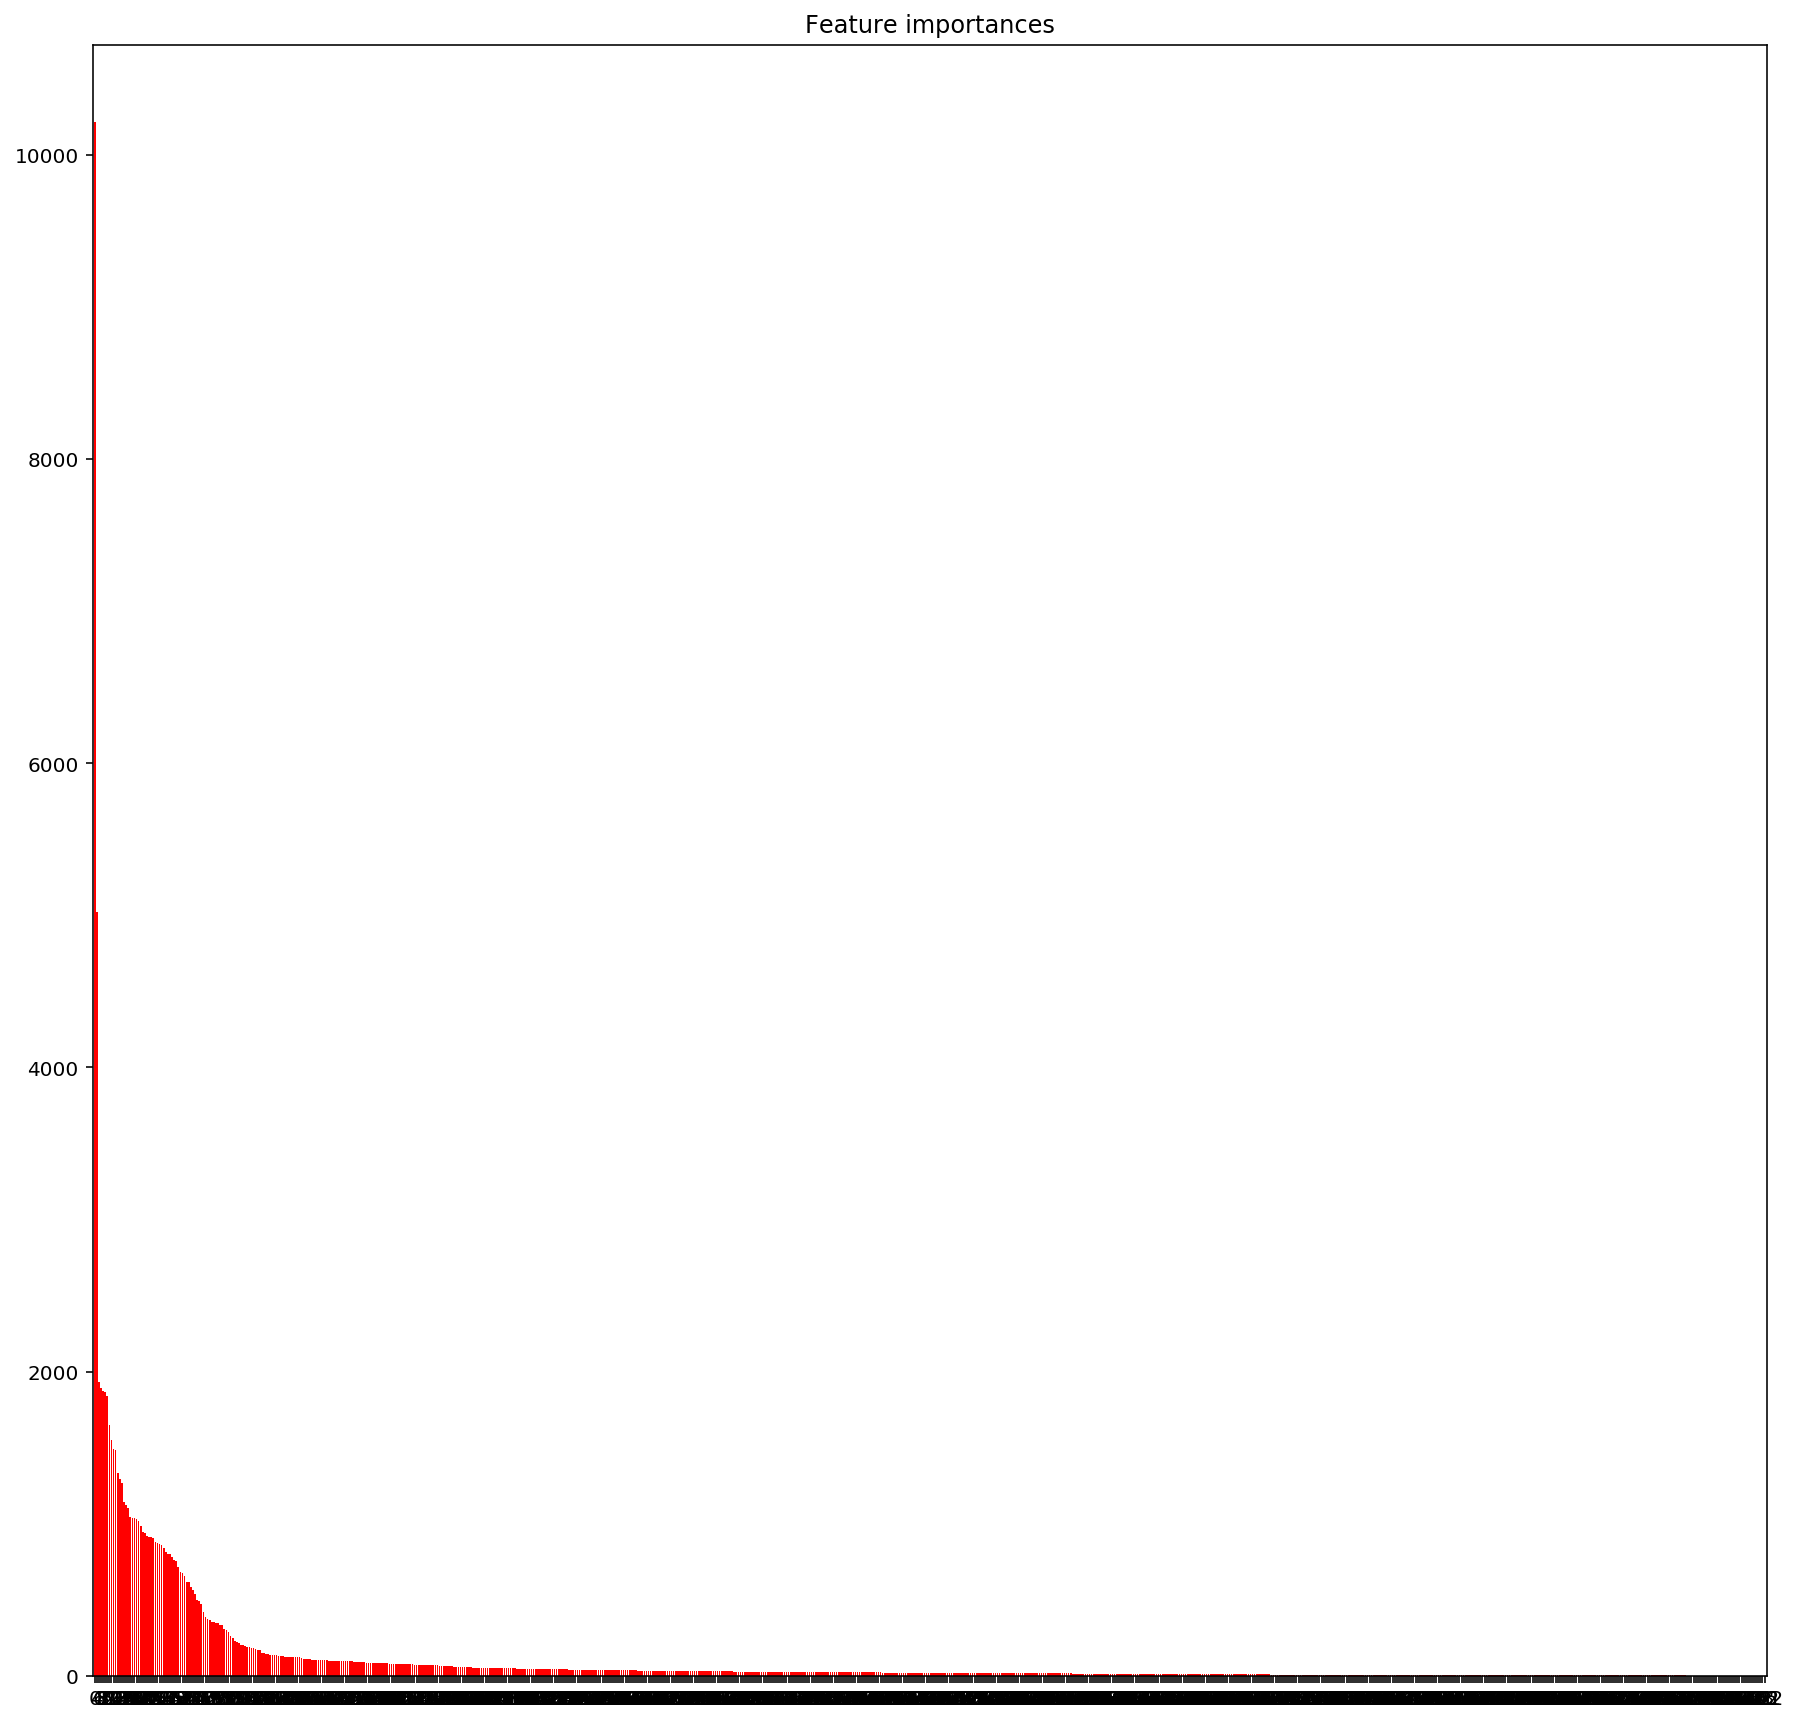

In [180]:
importances_best_model = lgb_best_model.feature_importances_

# std = np.std([tree.feature_importances_ for tree in lgb_best_model.estimators_], axis=0)
indices = np.argsort(importances_best_model)[::-1]

forest_feature_list = []
print("Feature ranking:")
for f in range(X1_reduced_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1,X1_reduced_train.columns[indices[f]], importances_best_model[indices[f]]))
    forest_feature_list.append(X1_reduced_train.columns[indices[f]])
    

plt.figure(figsize=(15,15))
plt.title("Feature importances")
plt.bar(range(X1_reduced_train.shape[1]), importances_best_model[indices], color="r", align="center")
plt.xticks(range(X1_reduced_train.shape[1]), indices)
plt.xlim([-1, X1_reduced_train.shape[1]])
plt.show()

'''
Feature ranking:
1. feature ScanCount (10329.000000)
2. feature VisitNumber (5069.000000)
3. feature PHARMACY OTC (1919.000000)
4. feature DSD GROCERY (1899.000000)
5. feature PRODUCE (1886.000000)
6. feature PERSONAL CARE (1868.000000)
7. feature GROCERY DRY GOODS (1810.000000)
8. feature IMPULSE MERCHANDISE (1657.000000)
9. feature MENS WEAR (1541.000000)
10. feature BEAUTY (1485.000000)
11. feature DAIRY (1483.000000)
12. feature scancount_mean (1358.000000)
13. feature HOUSEHOLD CHEMICALS/SUPP (1269.000000)
14. feature HOUSEHOLD PAPER GOODS (1254.000000)
15. feature TOYS (1134.000000)
16. feature FROZEN FOODS (1114.000000)
17. feature COOK AND DINE (1086.000000)
18. feature HARDWARE (1043.000000)
19. feature SPORTING GOODS (1026.000000)
20. feature PETS AND SUPPLIES (1021.000000)
21. feature SHOES (1016.000000)
22. feature max_by_mean (1004.000000)
23. feature HOME MANAGEMENT (975.000000)
24. feature SERVICE DELI (954.000000)
25. feature LADIESWEAR (954.000000)
26. feature CELEBRATION (914.000000)
27. feature INFANT CONSUMABLE HARDLINES (899.000000)
28. feature CANDY, TOBACCO, COOKIES (899.000000)
29. feature MEAT - FRESH & FROZEN (897.000000)
30. feature mean_by_min (890.000000)
31. feature OFFICE SUPPLIES (874.000000)
32. feature FABRICS AND CRAFTS (873.000000)
33. feature Pct_F_D (838.000000)
34. feature LAWN AND GARDEN (825.000000)
35. feature INFANT APPAREL (818.000000)
36. feature COMM BREAD (813.000000)
37. feature ELECTRONICS (799.000000)
38. feature FINANCIAL SERVICES (775.000000)
39. feature BAKERY (743.000000)
40. feature AUTOMOTIVE (738.000000)
41. feature Return (712.000000)
42. feature BATH AND SHOWER (677.000000)
43. feature MEDIA AND GAMING (676.000000)
44. feature GIRLS WEAR, 4-6X  AND 7-14 (668.000000)
45. feature HOME DECOR (624.000000)
46. feature LIQUOR,WINE,BEER (604.000000)
47. feature Pct_U_D (580.000000)
48. feature PRE PACKED DELI (579.000000)
49. feature JEWELRY AND SUNGLASSES (545.000000)
50. feature WIRELESS (500.000000)
'''

## Sumission Creator

In [182]:
predict_prob = lgb_best_model.predict_proba(X1_reduced_test).astype(float)

In [183]:
# submission_format('submit_alpha1_11.csv')

(95674, 39)


## RESULT

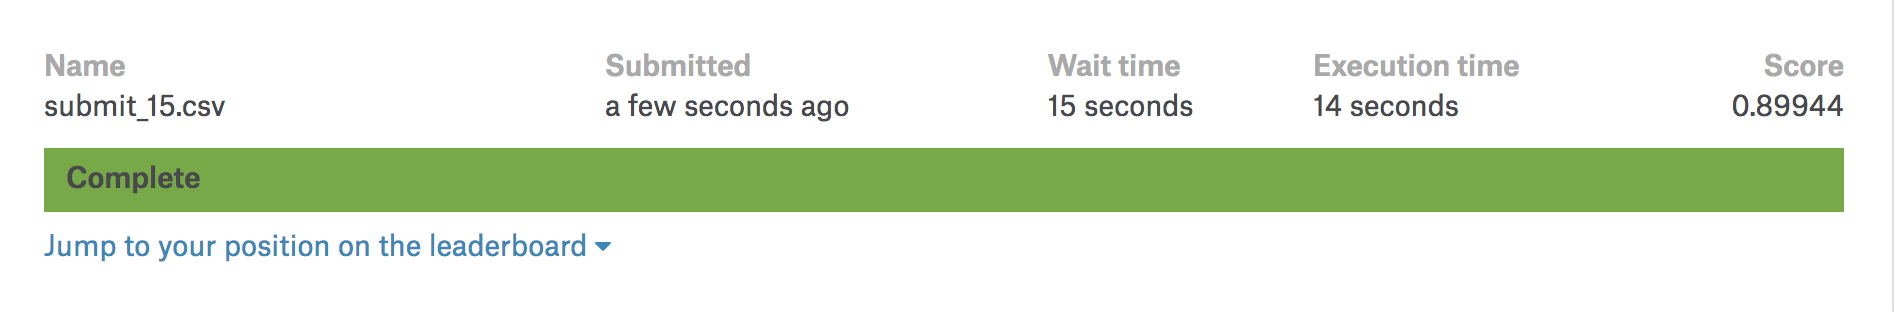

In [184]:
from PIL import Image as pil
pil.open('col800_est100.png')

#### 375/1047

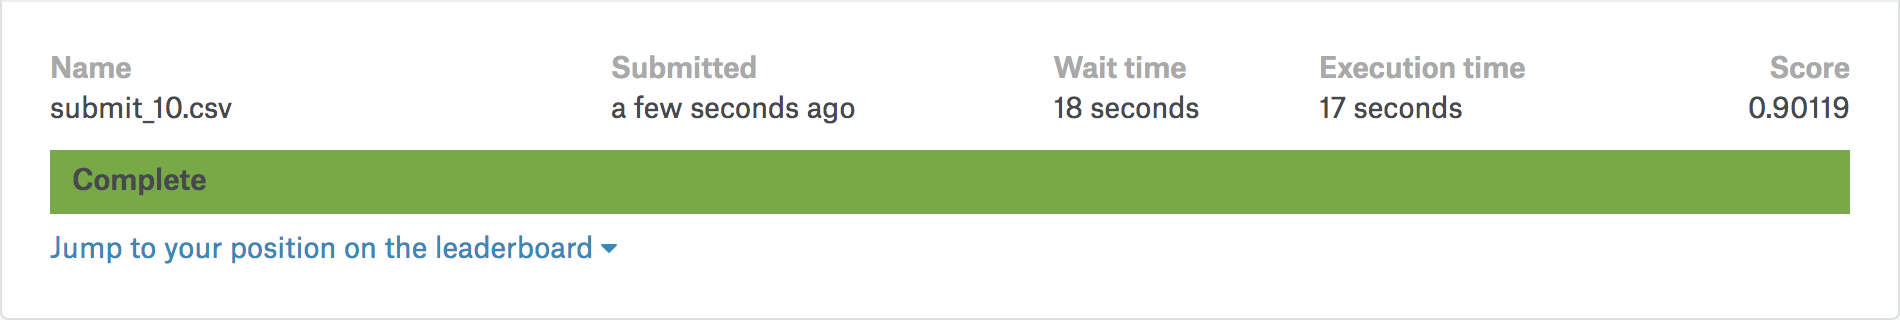

In [185]:
from PIL import Image as pil
pil.open('release_overfittin.png')

#### 375/1047